In [1]:
import os
import pandas as pd
import numpy as np
from utils.helpers import get_git_root

In [2]:
root_path = get_git_root()

In [3]:
human_ratings_path = os.path.join(
    root_path,
    "llm_selection",
    "data",
    "postselection_meme_ratings_processed.csv"
)

llm_judge_results_path = os.path.join(
    root_path,
    "llm_judge",
    "plots",
    "2025_02_21_23_04_10.csv"  
)

In [4]:
df_judge = pd.read_csv(llm_judge_results_path)
df_human = pd.read_csv(human_ratings_path)

In [5]:
# Display basic information about the dataset
print("Dataset shape:", df_judge.shape)
print("\nColumns in the dataset:")
print(df_judge.columns.tolist())

# Check for missing values
print("\nMissing values per column:")
print(df_judge.isnull().sum())

# Display the unique values for categorical columns
print("\nUnique models as judges:", df_judge['model_name_judge'].unique())
print("Number of claims:", df_judge['claim_number'].nunique())
print("Number of memes per claim:", df_judge['meme_number'].nunique())
print("Evaluation modes:", df_judge['evaluation_mode'].unique())

# Display a sample of the data
print("\nSample of the dataset:")
print(df_judge.head())

# Check the format of the rating columns
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']
print("\nRating column formats:")
for col in rating_columns:
    print(f"{col} unique values:", df_judge[col].unique()[:5])

# Count of evaluations by each model
print("\nCount of evaluations by each model:")
model_counts = df_judge['model_name_judge'].value_counts()
print(model_counts)

# Check if models rate their own memes higher
print("\nChecking self-rating bias (counts):")
self_vs_others = df_judge.groupby('is_own_meme').size()
print(self_vs_others)

# Compare deterministic vs creative mode (counts)
print("\nDeterministic vs Creative mode distribution:")
mode_comparison = df_judge.groupby('evaluation_mode').size()
print(mode_comparison)

# Display distribution of self-reported confidence values
print("\nSelf-reported confidence distribution:")
print(df_judge['self_reported_confidence'].value_counts().head(10))

# Check count of datapoints with error flag
print("\nCount of datapoints with error flag:")
print(df_judge['error'].value_counts())

Dataset shape: (7680, 20)

Columns in the dataset:
['model_name_judge', 'claim_number', 'meme_number', 'evaluation_mode', 'repetition_number', 'real_meme_url', 'bad_example_memes', 'good_example_memes', 'self_reported_meme_url', 'meme_description', 'coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness', 'self_reported_confidence', 'explanation', 'is_own_meme', 'real_confidence', 'error']

Missing values per column:
model_name_judge               0
claim_number                   0
meme_number                    0
evaluation_mode                0
repetition_number              0
real_meme_url                  0
bad_example_memes              0
good_example_memes             0
self_reported_meme_url         0
meme_description               0
coherence                      0
clarity                        0
hilarity                       0
persuasiveness                 0
template_appropriateness       0
self_reported_confidence       0
explanation                

In [24]:
# Process rating values from X/5 format to numeric values

# Function to convert ratings from "X/5" format to float
def convert_rating(rating_str):
    if pd.isna(rating_str):
        return np.nan
    try:
        # Extract the numeric value before the slash
        return float(rating_str.split('/')[0])
    except (AttributeError, ValueError, IndexError):
        # In case there's an unexpected format
        return np.nan

# Create a copy of the dataframe to avoid modifying the original
df_judge_processed = df_judge.copy()

# Convert rating columns from strings to numeric values
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']
for col in rating_columns:
    df_judge_processed[col] = df_judge_processed[col].apply(convert_rating)

# Convert self_reported_confidence from percentage string to float (0-1)
def convert_confidence(conf_str):
    if pd.isna(conf_str):
        return np.nan
    try:
        # Remove the % sign and convert to float, then divide by 100
        return float(conf_str.strip('%')) / 100
    except (AttributeError, ValueError):
        return np.nan

df_judge_processed['self_reported_confidence'] = df_judge_processed['self_reported_confidence'].apply(convert_confidence)

# Display basic statistics for the processed rating columns
print("Basic statistics for processed ratings:")
print(df_judge_processed[rating_columns].describe())

# Check the correlation between different rating dimensions
print("\nCorrelation between rating dimensions:")
print(df_judge_processed[rating_columns].corr())

# Display average ratings by model
print("\nAverage ratings by model:")
model_ratings = df_judge_processed.groupby('model_name_judge')[rating_columns].mean()
print(model_ratings)

# Add an overall average rating column
model_ratings['overall_avg'] = model_ratings.mean(axis=1)
print("\nOverall average rating by model (sorted):")
print(model_ratings['overall_avg'].sort_values(ascending=False))

# Display average ratings by evaluation mode
print("\nAverage ratings by evaluation mode:")
mode_ratings = df_judge_processed.groupby('evaluation_mode')[rating_columns].mean()
print(mode_ratings)

# Self-rating bias analysis
print("\nSelf-rating bias analysis:")
self_ratings = df_judge_processed.groupby('is_own_meme')[rating_columns].mean()
print(self_ratings)

# Save the processed dataframe
processed_path = os.path.join(root_path, "llm_judge", "processed", "judge_results_processed_phase1.csv")
os.makedirs(os.path.dirname(processed_path), exist_ok=True)
df_judge_processed.to_csv(processed_path, index=False)
print(f"\nProcessed data saved to {processed_path}")

Basic statistics for processed ratings:
         coherence      clarity     hilarity  persuasiveness  \
count  7680.000000  7680.000000  7680.000000     7680.000000   
mean      4.156120     4.331771     3.580990        3.983984   
std       0.557632     0.604994     0.649524        0.743687   
min       1.000000     1.000000     1.000000        1.000000   
25%       4.000000     4.000000     3.000000        4.000000   
50%       4.000000     4.000000     4.000000        4.000000   
75%       4.000000     5.000000     4.000000        4.000000   
max       5.000000     5.000000     5.000000        5.000000   

       template_appropriateness  
count               7680.000000  
mean                   4.366016  
std                    0.696028  
min                    1.000000  
25%                    4.000000  
50%                    4.000000  
75%                    5.000000  
max                    5.000000  

Correlation between rating dimensions:
                          coherence  

In [32]:
# Visualize mean ratings by model and evaluation mode

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set nicer plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Get mean ratings by model and mode
model_mode_ratings = df_judge_processed.groupby(['model_name_judge', 'evaluation_mode'])[rating_columns].mean()

# Reset index to make plotting easier
model_mode_ratings_reset = model_mode_ratings.reset_index()

# Create a figure with subplots - one for each rating dimension plus overall average
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Add overall average rating
model_mode_ratings_reset['overall_avg'] = model_mode_ratings_reset[rating_columns].mean(axis=1)

# Plot each rating dimension
for i, col in enumerate(rating_columns + ['overall_avg']):
    ax = axes[i]
    sns.barplot(
        x='model_name_judge', 
        y=col, 
        hue='evaluation_mode',
        data=model_mode_ratings_reset,
        ax=ax
    )
    ax.set_title(f"{col.capitalize()}", fontsize=14)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Average Rating", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Evaluation Mode")

# Adjust layout
plt.tight_layout()
plt.savefig("model_mode_comparison.png")
plt.close()

# Create a table showing the differences between deterministic and creative modes
print("Difference in ratings between evaluation modes (Creative - Deterministic):")

# Alternative approach without unstack
# Get deterministic mode ratings
deterministic_ratings = df_judge_processed[df_judge_processed['evaluation_mode'] == 'deterministic'].groupby('model_name_judge')[rating_columns].mean()

# Get creative mode ratings
creative_ratings = df_judge_processed[df_judge_processed['evaluation_mode'] == 'creative'].groupby('model_name_judge')[rating_columns].mean()

# Calculate difference
mode_diff = creative_ratings - deterministic_ratings
mode_diff['overall_avg'] = mode_diff.mean(axis=1)
print(mode_diff)

# Create a heatmap visualization of the differences
plt.figure(figsize=(12, 8))
sns.heatmap(
    mode_diff, 
    annot=True, 
    cmap="RdBu_r", 
    center=0, 
    fmt=".2f",
    linewidths=.5
)
plt.title("Difference in Ratings: Creative - Deterministic Modes", fontsize=16)
plt.tight_layout()
plt.savefig("mode_difference_heatmap.png")
plt.close()

# Statistical analysis - t-test for differences between modes for each model
print("\nStatistical analysis of differences between modes:")
for model in df_judge_processed['model_name_judge'].unique():
    model_data = df_judge_processed[df_judge_processed['model_name_judge'] == model]
    
    # Calculate average rating across all dimensions for each evaluation
    model_data['overall_score'] = model_data[rating_columns].mean(axis=1)
    
    determ_scores = model_data[model_data['evaluation_mode'] == 'deterministic']['overall_score']
    creative_scores = model_data[model_data['evaluation_mode'] == 'creative']['overall_score']
    
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(creative_scores, determ_scores, equal_var=False)
    mean_diff = creative_scores.mean() - determ_scores.mean()
    
    result = f"* SIGNIFICANT" if p_value < 0.05 else "  Not significant"
    direction = "higher" if mean_diff > 0 else "lower"
    
    print(f"{model}: Creative mode ratings are {direction} by {abs(mean_diff):.4f} (p={p_value:.4f}) {result}")

# Create a grouped bar chart for a clearer comparison across models and modes
# Melt the dataframe to make it easier to plot
model_mode_ratings_melted = model_mode_ratings_reset.melt(
    id_vars=['model_name_judge', 'evaluation_mode'],
    value_vars=rating_columns,
    var_name='Rating Dimension',
    value_name='Average Rating'
)

# Create a separate plot for easier viewing - comparing modes for each model across all dimensions
plt.figure(figsize=(15, 10))
g = sns.catplot(
    kind='bar',
    x='model_name_judge',
    y='Average Rating',
    hue='evaluation_mode',
    col='Rating Dimension',
    data=model_mode_ratings_melted,
    col_wrap=3,
    height=4,
    aspect=1.2
)
plt.tight_layout()
g.savefig("detailed_mode_comparison.png")
plt.close()

Difference in ratings between evaluation modes (Creative - Deterministic):
                    coherence   clarity  hilarity  persuasiveness  \
model_name_judge                                                    
claude-3.5-sonnet    0.003125 -0.005208  0.013542       -0.003125   
gemini-1.5-pro      -0.014583  0.004167 -0.014583       -0.004167   
gpt-4o              -0.008333  0.050000  0.096875       -0.033333   
pixtral-large-2411   0.052083  0.059375  0.056250        0.072917   

                    template_appropriateness  overall_avg  
model_name_judge                                           
claude-3.5-sonnet                   0.012500     0.004167  
gemini-1.5-pro                     -0.028125    -0.011458  
gpt-4o                             -0.001042     0.020833  
pixtral-large-2411                  0.021875     0.052500  

Statistical analysis of differences between modes:
pixtral-large-2411: Creative mode ratings are higher by 0.0525 (p=0.0022) * SIGNIFICANT
gemini-1.5

/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_11371/905309882.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['overall_score'] = model_data[rating_columns].mean(axis=1)
/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_11371/905309882.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['overall_score'] = model_data[rating_columns].mean(axis=1)
/var/folders/fv/vf3sjpn92ql19dv_1bf4dl1m0000gn/T/ipykernel_11371/905309882.py:82: SettingWithCopyWarning: 
A value i

<Figure size 1500x1000 with 0 Axes>

In [26]:
# Create a mini dataset with random rows for quick testing and exploration
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Sample 100 random rows from the processed dataframe
df_mini = df_judge_processed.sample(n=100, random_state=42)

# Display basic information about the mini dataset
print(f"Mini dataset shape: {df_mini.shape}")
print(f"Models included: {df_mini['model_name_judge'].unique()}")
print(f"Claims included: {df_mini['claim_number'].unique()}")
print(f"Memes included: {df_mini['meme_number'].unique()}")

# Distribution of models in the mini dataset
print("\nDistribution of models in mini dataset:")
print(df_mini['model_name_judge'].value_counts())

# Save the mini dataset
mini_path = os.path.join(root_path, "llm_judge", "processed", "judge_results_mini.csv")
df_mini.to_csv(mini_path, index=False)
print(f"\nMini dataset saved to {mini_path}")

# Optional: Create a version with simplified columns for even quicker analysis
mini_simple_cols = [
    'model_name_judge', 'claim_number', 'meme_number', 'evaluation_mode', 
    'coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness',
    'is_own_meme', 'real_confidence'
]

df_mini_simple = df_mini[mini_simple_cols]
simple_mini_path = os.path.join(root_path, "llm_judge", "processed", "judge_results_mini_simple.csv")
df_mini_simple.to_csv(simple_mini_path, index=False)
print(f"Simplified mini dataset saved to {simple_mini_path}")

# Show a sample of the mini dataset
print("\nSample of the mini dataset:")
print(df_mini_simple.head())

Mini dataset shape: (100, 20)
Models included: ['claude-3.5-sonnet' 'gpt-4o' 'pixtral-large-2411' 'gemini-1.5-pro']
Claims included: [ 2  4 10  6 11  8  1  9  5  7 12  3]
Memes included: [4 8 7 1 5 2 6 3]

Distribution of models in mini dataset:
model_name_judge
pixtral-large-2411    32
claude-3.5-sonnet     28
gpt-4o                20
gemini-1.5-pro        20
Name: count, dtype: int64

Mini dataset saved to /Users/sergiopinto/Desktop/MemeFact/llm_judge/processed/judge_results_mini.csv
Simplified mini dataset saved to /Users/sergiopinto/Desktop/MemeFact/llm_judge/processed/judge_results_mini_simple.csv

Sample of the mini dataset:
        model_name_judge  claim_number  meme_number evaluation_mode  \
5992   claude-3.5-sonnet             2            4        creative   
4466              gpt-4o             4            8   deterministic   
1575  pixtral-large-2411            10            7        creative   
4787              gpt-4o             6            8   deterministic   
3538  

In [28]:
# Analysis of GPT-4o confidence and self-rating bias

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import re

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# 1. Analyze GPT-4o's real confidence vs self-reported confidence
print("===== GPT-4o Confidence Analysis =====")

# Filter for GPT-4o data with non-null confidence values
gpt4o_df = df_judge_processed[df_judge_processed['model_name_judge'] == 'gpt-4o'].copy()
gpt4o_confidence = gpt4o_df[gpt4o_df['real_confidence'].notna()]

# Convert real_confidence to float if it's in string format
def convert_percentage_to_float(value):
    if isinstance(value, str):
        # Extract numeric value using regex
        match = re.search(r'([\d.]+)', value)
        if match:
            return float(match.group(1)) / 100
    return value

gpt4o_confidence['real_confidence'] = gpt4o_confidence['real_confidence'].apply(convert_percentage_to_float)

# Calculate basic statistics
print(f"Number of GPT-4o evaluations with confidence data: {len(gpt4o_confidence)}")
print("\nReal confidence statistics:")
print(gpt4o_confidence['real_confidence'].describe())
print("\nSelf-reported confidence statistics:")
print(gpt4o_confidence['self_reported_confidence'].describe())

# Calculate correlation between real and self-reported confidence
corr, p_value = pearsonr(
    gpt4o_confidence['real_confidence'],
    gpt4o_confidence['self_reported_confidence']
)

print(f"\nCorrelation between real and self-reported confidence: {corr:.4f} (p-value: {p_value:.4f})")

# Is GPT-4o over-confident or under-confident?
confidence_diff = gpt4o_confidence['self_reported_confidence'] - gpt4o_confidence['real_confidence']
print(f"Mean difference (self-reported - real): {confidence_diff.mean():.4f}")
print(f"Median difference: {confidence_diff.median():.4f}")

# Count overconfident vs underconfident instances
overconfident = (confidence_diff > 0).sum()
underconfident = (confidence_diff < 0).sum()
equal_confident = (confidence_diff == 0).sum()
print(f"Overconfident instances: {overconfident} ({overconfident/len(confidence_diff)*100:.1f}%)")
print(f"Underconfident instances: {underconfident} ({underconfident/len(confidence_diff)*100:.1f}%)")
print(f"Equal confidence instances: {equal_confident} ({equal_confident/len(confidence_diff)*100:.1f}%)")

# Plot the relationship
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='real_confidence', y='self_reported_confidence', data=gpt4o_confidence)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Add identity line
plt.title("GPT-4o Real Confidence vs Self-Reported Confidence")
plt.xlabel("Real Confidence")
plt.ylabel("Self-Reported Confidence")
plt.grid(True)
plt.savefig("gpt4o_confidence_comparison.png")
plt.close()

# 2. Analyze Self-Rating Bias
print("\n\n===== Self-Rating Bias Analysis =====")

# Rating columns
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']

# Create an overall score column (average of all rating dimensions)
df_judge_processed['overall_score'] = df_judge_processed[rating_columns].mean(axis=1)

# Calculate average ratings by model when rating its own memes vs others
self_bias_df = df_judge_processed.groupby(['model_name_judge', 'is_own_meme'])[
    rating_columns + ['overall_score']
].mean().reset_index()

# Pivot the table for easier comparison
pivot_table = self_bias_df.pivot(index='model_name_judge', columns='is_own_meme')

# Display mean ratings for each model (own memes vs others) for overall score
print("Mean overall ratings - own memes vs others:")
comparison_overall = pd.DataFrame({
    'Other Memes': pivot_table[('overall_score', False)],
    'Own Memes': pivot_table[('overall_score', True)],
    'Difference': pivot_table[('overall_score', True)] - pivot_table[('overall_score', False)]
})
print(comparison_overall)

# Display mean ratings for each dimension
for col in rating_columns:
    print(f"\n{col.capitalize()} ratings - own memes vs others:")
    comparison = pd.DataFrame({
        'Other Memes': pivot_table[(col, False)],
        'Own Memes': pivot_table[(col, True)],
        'Difference': pivot_table[(col, True)] - pivot_table[(col, False)]
    })
    print(comparison)

# Statistical tests for each model
print("\nStatistical Analysis of Self-Rating Bias:")
for model in df_judge_processed['model_name_judge'].unique():
    model_data = df_judge_processed[df_judge_processed['model_name_judge'] == model]
    
    # Skip if no self-ratings for this model
    if True not in model_data['is_own_meme'].values:
        print(f"{model}: No self-ratings available")
        continue
    
    own_scores = model_data[model_data['is_own_meme'] == True]['overall_score']
    other_scores = model_data[model_data['is_own_meme'] == False]['overall_score']
    
    # Only perform t-test if we have enough data
    if len(own_scores) > 1 and len(other_scores) > 1:
        t_stat, p_value = ttest_ind(own_scores, other_scores, equal_var=False)
        mean_diff = own_scores.mean() - other_scores.mean()
        print(f"{model}: Mean diff = {mean_diff:.4f}, t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"  * SIGNIFICANT BIAS: {model} {'favors' if mean_diff > 0 else 'disfavors'} its own memes")
    else:
        print(f"{model}: Insufficient data for statistical test")

# Plot average scores by model for own vs other memes
plt.figure(figsize=(12, 6))
self_bias_plot = self_bias_df.copy()
self_bias_plot['is_own_meme'] = self_bias_plot['is_own_meme'].map({True: 'Own Memes', False: 'Other Memes'})
ax = sns.barplot(x='model_name_judge', y='overall_score', hue='is_own_meme', data=self_bias_plot)
plt.title("Average Ratings: Own Memes vs Other Memes")
plt.xlabel("Model")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("self_rating_bias.png")
plt.close()

===== GPT-4o Confidence Analysis =====
Number of GPT-4o evaluations with confidence data: 1920

Real confidence statistics:
count    1920.000000
mean        0.786282
std         0.110673
min         0.368200
25%         0.707050
50%         0.790900
75%         0.872625
max         0.979200
Name: real_confidence, dtype: float64

Self-reported confidence statistics:
count    1920.000000
mean        0.925615
std         0.031063
min         0.800000
25%         0.900000
50%         0.950000
75%         0.950000
max         1.000000
Name: self_reported_confidence, dtype: float64

Correlation between real and self-reported confidence: 0.3964 (p-value: 0.0000)
Mean difference (self-reported - real): 0.1393
Median difference: 0.1295
Overconfident instances: 1818 (94.7%)
Underconfident instances: 102 (5.3%)
Equal confidence instances: 0 (0.0%)


===== Self-Rating Bias Analysis =====
Mean overall ratings - own memes vs others:
                    Other Memes  Own Memes  Difference
model_name_j

In [29]:
# Extract just the GPT-4o confidence analysis portion with rounded values

# Filter for GPT-4o data with non-null confidence values
gpt4o_df = df_judge_processed[df_judge_processed['model_name_judge'] == 'gpt-4o'].copy()
gpt4o_confidence = gpt4o_df[gpt4o_df['real_confidence'].notna()]

# Convert real_confidence to float if it's in string format
def convert_percentage_to_float(value):
    if isinstance(value, str):
        # Extract numeric value using regex
        match = re.search(r'([\d.]+)', value)
        if match:
            return float(match.group(1)) / 100
    return value

gpt4o_confidence['real_confidence'] = gpt4o_confidence['real_confidence'].apply(convert_percentage_to_float)

# Round real_confidence to match the precision of self-reported confidence
# Most self-reported values are in increments of 5% (0.05), so round to that
gpt4o_confidence['real_confidence_rounded'] = (gpt4o_confidence['real_confidence'] * 20).round() / 20

# Display basic statistics
print("===== GPT-4o Confidence Analysis with Rounded Values =====")
print(f"Number of GPT-4o evaluations with confidence data: {len(gpt4o_confidence)}")

print("\nOriginal real confidence statistics:")
print(gpt4o_confidence['real_confidence'].describe())

print("\nRounded real confidence statistics:")
print(gpt4o_confidence['real_confidence_rounded'].describe())

print("\nSelf-reported confidence statistics:")
print(gpt4o_confidence['self_reported_confidence'].describe())

# Calculate correlation with rounded values
corr, p_value = pearsonr(
    gpt4o_confidence['real_confidence_rounded'],
    gpt4o_confidence['self_reported_confidence']
)

print(f"\nCorrelation between rounded real and self-reported confidence: {corr:.4f} (p-value: {p_value:.4f})")

# Is GPT-4o over-confident or under-confident using rounded values?
confidence_diff = gpt4o_confidence['self_reported_confidence'] - gpt4o_confidence['real_confidence_rounded']

# Count exact matches, overconfident and underconfident instances
equal_confident = (confidence_diff == 0).sum()
overconfident = (confidence_diff > 0).sum()
underconfident = (confidence_diff < 0).sum()

print("\nConfidence comparison (using rounded real confidence):")
print(f"Exact match instances: {equal_confident} ({equal_confident/len(confidence_diff)*100:.1f}%)")
print(f"Overconfident instances: {overconfident} ({overconfident/len(confidence_diff)*100:.1f}%)")
print(f"Underconfident instances: {underconfident} ({underconfident/len(confidence_diff)*100:.1f}%)")

print(f"\nMean difference (self-reported - rounded real): {confidence_diff.mean():.4f}")
print(f"Median difference: {confidence_diff.median():.4f}")

# Distribution of differences
print("\nDistribution of confidence differences:")
diff_counts = confidence_diff.value_counts().sort_index()
for diff, count in diff_counts.items():
    print(f"  Difference of {diff:.2f}: {count} instances ({count/len(confidence_diff)*100:.1f}%)")

# Plot the relationship with rounded values
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x='real_confidence_rounded', 
    y='self_reported_confidence', 
    data=gpt4o_confidence,
    alpha=0.5,
    s=100
)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Add identity line
plt.title("GPT-4o Rounded Real Confidence vs Self-Reported Confidence")
plt.xlabel("Real Confidence (Rounded to nearest 5%)")
plt.ylabel("Self-Reported Confidence")
plt.grid(True)
plt.savefig("gpt4o_confidence_comparison_rounded.png")
plt.close()

===== GPT-4o Confidence Analysis with Rounded Values =====
Number of GPT-4o evaluations with confidence data: 1920

Original real confidence statistics:
count    1920.000000
mean        0.786282
std         0.110673
min         0.368200
25%         0.707050
50%         0.790900
75%         0.872625
max         0.979200
Name: real_confidence, dtype: float64

Rounded real confidence statistics:
count    1920.000000
mean        0.786172
std         0.110874
min         0.350000
25%         0.700000
50%         0.800000
75%         0.850000
max         1.000000
Name: real_confidence_rounded, dtype: float64

Self-reported confidence statistics:
count    1920.000000
mean        0.925615
std         0.031063
min         0.800000
25%         0.900000
50%         0.950000
75%         0.950000
max         1.000000
Name: self_reported_confidence, dtype: float64

Correlation between rounded real and self-reported confidence: 0.3945 (p-value: 0.0000)

Confidence comparison (using rounded real confi

In [33]:
# Analyze similarities between explanations for repeated evaluations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import warnings

# Download NLTK resources (run once)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Suppress warnings
warnings.filterwarnings('ignore')

# Preprocess text function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to string if not already
    text = str(text)
    
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate pairwise similarities within a group of explanations
def calculate_similarity_matrix(explanations):
    # Preprocess explanations
    processed_explanations = [preprocess_text(exp) for exp in explanations]
    
    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(processed_explanations)
    
    # Calculate pairwise cosine similarities
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    return similarity_matrix

# Function to calculate average similarity score for a group
def calculate_avg_similarity(similarity_matrix):
    # Extract upper triangle (excluding diagonal) for unique pairs
    n = similarity_matrix.shape[0]
    upper_tri_indices = np.triu_indices(n, k=1)
    upper_tri_values = similarity_matrix[upper_tri_indices]
    
    # Calculate average similarity
    if len(upper_tri_values) > 0:
        return np.mean(upper_tri_values)
    else:
        return np.nan

# Analyze explanation similarities
print("Analyzing explanation similarities...")

# Group data by model, claim_number, meme_number
model_claim_meme_groups = df_judge_processed.groupby(['model_name_judge', 'claim_number', 'meme_number'])

# Prepare plots containers
similarity_results = []
model_similarities = {}

# Process each group
for (model, claim, meme), group in tqdm(model_claim_meme_groups):
    # Skip if group is too small or has missing explanations
    if len(group) < 2 or group['explanation'].isna().any():
        continue
    
    # Get explanations for this group
    explanations = group['explanation'].tolist()
    
    # Calculate similarity matrix
    similarity_matrix = calculate_similarity_matrix(explanations)
    
    # Calculate average similarity for this group
    avg_similarity = calculate_avg_similarity(similarity_matrix)
    
    # Store plots
    similarity_results.append({
        'model': model,
        'claim': claim,
        'meme': meme,
        'avg_similarity': avg_similarity,
        'deterministic_count': sum(group['evaluation_mode'] == 'deterministic'),
        'creative_count': sum(group['evaluation_mode'] == 'creative'),
        'is_own_meme': group['is_own_meme'].iloc[0]
    })
    
    # Track similarities by model
    if model not in model_similarities:
        model_similarities[model] = []
    model_similarities[model].append(avg_similarity)

# Convert plots to DataFrame
similarity_df = pd.DataFrame(similarity_results)

# Calculate overall average similarities by model
model_avg_similarities = {model: np.mean(sims) for model, sims in model_similarities.items()}
print("\nAverage explanation similarity by model:")
for model, avg_sim in sorted(model_avg_similarities.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {avg_sim:.4f}")

# Analyze by evaluation mode
print("\nAnalyzing similarities by evaluation mode...")
mode_similarity_results = []

# Group by model, claim, meme, and mode
mode_groups = df_judge_processed.groupby(['model_name_judge', 'claim_number', 'meme_number', 'evaluation_mode'])

for (model, claim, meme, mode), group in tqdm(mode_groups):
    # Skip if group is too small or has missing explanations
    if len(group) < 2 or group['explanation'].isna().any():
        continue
    
    # Get explanations
    explanations = group['explanation'].tolist()
    
    # Calculate similarity matrix
    similarity_matrix = calculate_similarity_matrix(explanations)
    
    # Calculate average similarity
    avg_similarity = calculate_avg_similarity(similarity_matrix)
    
    # Store plots
    mode_similarity_results.append({
        'model': model,
        'claim': claim,
        'meme': meme,
        'mode': mode,
        'avg_similarity': avg_similarity,
        'is_own_meme': group['is_own_meme'].iloc[0]
    })

# Convert to DataFrame
mode_similarity_df = pd.DataFrame(mode_similarity_results)

# Calculate average by model and mode
mode_model_avg = mode_similarity_df.groupby(['model', 'mode'])['avg_similarity'].mean().reset_index()
print("\nAverage similarity by model and evaluation mode:")
print(mode_model_avg.pivot(index='model', columns='mode', values='avg_similarity'))

# Compare similarity for own memes vs other memes
own_vs_other = similarity_df.groupby(['model', 'is_own_meme'])['avg_similarity'].mean().reset_index()
print("\nSimilarity for own memes vs other memes:")
print(own_vs_other.pivot(index='model', columns='is_own_meme', values='avg_similarity'))

# Visualization 1: Average similarity by model
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='avg_similarity', data=similarity_df, estimator=np.mean, ci=95)
plt.title('Average Explanation Similarity by Model', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Similarity (0-1)', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('explanation_similarity_by_model.png')
plt.close()

# Visualization 2: Similarity by model and mode
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='avg_similarity', hue='mode', data=mode_similarity_df)
plt.title('Explanation Similarity by Model and Evaluation Mode', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Similarity (0-1)', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Evaluation Mode')
plt.tight_layout()
plt.savefig('explanation_similarity_by_mode.png')
plt.close()

# Visualization 3: Own meme vs other meme similarity 
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='avg_similarity', hue='is_own_meme', 
            data=similarity_df,
            hue_order=[False, True],
            palette=['skyblue', 'coral'])
plt.title('Explanation Similarity: Own Memes vs Other Memes', fontsize=15)
plt.xlabel('Model', fontsize=12) 
plt.ylabel('Average Similarity (0-1)', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Is Own Meme', labels=['Other Memes', 'Own Memes'])
plt.tight_layout()
plt.savefig('explanation_similarity_own_vs_other.png')
plt.close()

# Visualization 4: Distribution of similarities by model
plt.figure(figsize=(12, 8))
sns.boxplot(x='model', y='avg_similarity', data=similarity_df)
sns.stripplot(x='model', y='avg_similarity', data=similarity_df, 
              size=4, color='black', alpha=0.3)
plt.title('Distribution of Explanation Similarities by Model', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Similarity (0-1)', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('explanation_similarity_distribution.png')
plt.close()

# Cross-model similarity analysis
print("\nAnalyzing cross-model similarities...")

# Function to get most common memes evaluated by all models
def get_common_memes(df, min_count=5):
    # Count memes evaluated by each model
    meme_counts = df.groupby(['model_name_judge', 'claim_number', 'meme_number']).size().reset_index(name='count')
    
    # Filter for memes with enough evaluations
    meme_counts = meme_counts[meme_counts['count'] >= min_count]
    
    # Find memes evaluated by all models
    meme_model_counts = meme_counts.groupby(['claim_number', 'meme_number']).size().reset_index(name='model_count')
    common_memes = meme_model_counts[meme_model_counts['model_count'] == len(df['model_name_judge'].unique())]
    
    return common_memes

common_memes = get_common_memes(df_judge_processed)
print(f"Found {len(common_memes)} memes evaluated by all models")

# Analyze cross-model similarities for common memes
cross_model_results = []

for _, row in tqdm(common_memes.iterrows(), total=len(common_memes)):
    claim, meme = row['claim_number'], row['meme_number']
    
    # Get explanations for this meme from each model
    meme_data = df_judge_processed[(df_judge_processed['claim_number'] == claim) & 
                                  (df_judge_processed['meme_number'] == meme)]
    
    # Get representative explanation from each model (using mode='deterministic' for consistency)
    model_explanations = {}
    for model in df_judge_processed['model_name_judge'].unique():
        model_det_expl = meme_data[(meme_data['model_name_judge'] == model) & 
                                  (meme_data['evaluation_mode'] == 'deterministic')]
        if not model_det_expl.empty:
            # Use first explanation as representative
            model_explanations[model] = model_det_expl['explanation'].iloc[0]
    
    # Skip if we don't have explanations from all models
    if len(model_explanations) < len(df_judge_processed['model_name_judge'].unique()):
        continue
    
    # Calculate cross-model similarities
    models = list(model_explanations.keys())
    explanations = [model_explanations[model] for model in models]
    
    # Calculate similarity matrix
    similarity_matrix = calculate_similarity_matrix(explanations)
    
    # For each pair of models
    for i in range(len(models)):
        for j in range(i+1, len(models)):
            cross_model_results.append({
                'model1': models[i],
                'model2': models[j],
                'claim': claim,
                'meme': meme,
                'similarity': similarity_matrix[i, j]
            })

# Convert to DataFrame
cross_model_df = pd.DataFrame(cross_model_results)

# Calculate average cross-model similarities
cross_model_avg = cross_model_df.groupby(['model1', 'model2'])['similarity'].mean().reset_index()
cross_model_pivot = cross_model_avg.pivot(index='model1', columns='model2', values='similarity')

print("\nAverage cross-model explanation similarities:")
print(cross_model_pivot)

# Visualization 5: Cross-model similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_model_pivot, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.3f')
plt.title('Cross-Model Explanation Similarity', fontsize=15)
plt.tight_layout()
plt.savefig('cross_model_similarity_heatmap.png')
plt.close()

print("\nAnalysis complete! Check the saved PNG files for visualizations.")

Analyzing explanation similarities...


100%|██████████| 384/384 [00:00<00:00, 449.33it/s]



Average explanation similarity by model:
claude-3.5-sonnet: 0.3501
pixtral-large-2411: 0.3481
gemini-1.5-pro: 0.3275
gpt-4o: 0.2721

Analyzing similarities by evaluation mode...


100%|██████████| 768/768 [00:01<00:00, 725.27it/s]



Average similarity by model and evaluation mode:
mode                creative  deterministic
model                                      
claude-3.5-sonnet   0.349580       0.438985
gemini-1.5-pro      0.344327       0.384606
gpt-4o              0.255690       0.372640
pixtral-large-2411  0.349683       0.433292

Similarity for own memes vs other memes:
is_own_meme            False     True 
model                                 
claude-3.5-sonnet   0.349248  0.356403
gemini-1.5-pro      0.326095  0.337442
gpt-4o              0.271254  0.278003
pixtral-large-2411  0.347691  0.351033

Analyzing cross-model similarities...
Found 96 memes evaluated by all models


100%|██████████| 96/96 [00:00<00:00, 468.48it/s]



Average cross-model explanation similarities:
model2              claude-3.5-sonnet  gemini-1.5-pro    gpt-4o
model1                                                         
gemini-1.5-pro               0.273118             NaN  0.269845
gpt-4o                       0.262246             NaN       NaN
pixtral-large-2411           0.280038        0.290104  0.333355

Analysis complete! Check the saved PNG files for visualizations.


In [35]:
# Simple exploration of the human ratings file

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Display information about the dataframe
print(f"Shape of human ratings data: {df_human.shape}")
print(f"Number of raters: {len(df_human)}")

# Get a list of all columns related to meme ratings (exclude 'none' columns)
meme_cols = [col for col in df_human.columns if ('meme' in col and 'none' not in col)]
print(f"Number of meme rating columns: {len(meme_cols)}")

# Count the number of claims and memes per claim
claim_pattern = re.compile(r'claim(\d+)_meme\d+')
unique_claims = set()
for col in meme_cols:
    match = claim_pattern.search(col)
    if match:
        unique_claims.add(match.group(1))
print(f"Number of unique claims: {len(unique_claims)}")

meme_pattern = re.compile(r'claim\d+_meme(\d+)')
unique_memes = set()
for col in meme_cols:
    match = meme_pattern.search(col)
    if match:
        unique_memes.add(match.group(1))
print(f"Number of unique memes per claim: {len(unique_memes)}")

# Check the rating dimensions
dimension_pattern = re.compile(r'claim\d+_meme\d+_(\w+)')
dimensions = set()
for col in meme_cols:
    match = dimension_pattern.search(col)
    if match:
        dimensions.add(match.group(1))
print(f"Rating dimensions: {', '.join(dimensions)}")

# Calculate missing values for meme rating columns
missing_values = df_human[meme_cols].isnull().sum()
missing_percent = (missing_values / len(df_human)) * 100
print("\nMissing values statistics:")
print(f"Average percentage of missing values: {missing_percent.mean():.2f}%")
print(f"Range of missing values: {missing_percent.min():.2f}% - {missing_percent.max():.2f}%")

# Calculate average rating across all memes for each dimension
avg_ratings_by_dimension = {}
for dimension in dimensions:
    dimension_cols = [col for col in meme_cols if col.endswith(f"_{dimension}")]
    avg_rating = df_human[dimension_cols].mean().mean()
    avg_ratings_by_dimension[dimension] = avg_rating

print("\nAverage ratings by dimension:")
for dimension, avg in avg_ratings_by_dimension.items():
    print(f"{dimension}: {avg:.2f}")

# Create a simple visualization of average ratings by dimension
plt.figure(figsize=(10, 6))
dimensions_list = list(avg_ratings_by_dimension.keys())
ratings_list = list(avg_ratings_by_dimension.values())
sns.barplot(x=dimensions_list, y=ratings_list)
plt.title('Average Ratings by Dimension')
plt.xlabel('Dimension')
plt.ylabel('Average Rating')
plt.ylim(0, 5)  # Assuming ratings are on a 0-5 scale
plt.tight_layout()
plt.savefig('human_ratings_by_dimension.png')
plt.close()

# Display a few sample values to understand the data format
print("\nSample values from the dataset:")
sample_cols = [col for col in meme_cols if 'claim1_meme1' in col]
print(df_human[sample_cols].head(3))

Shape of human ratings data: (110, 553)
Number of raters: 110
Number of meme rating columns: 480
Number of unique claims: 12
Number of unique memes per claim: 8
Rating dimensions: template_conveyance, coherence, persuasiveness, clarity, hilarity

Missing values statistics:
Average percentage of missing values: 89.50%
Range of missing values: 54.55% - 99.09%

Average ratings by dimension:
template_conveyance: 3.63
coherence: 3.67
persuasiveness: 3.37
clarity: 3.71
hilarity: 3.27

Sample values from the dataset:
   claim1_meme1_coherence  claim1_meme1_clarity  claim1_meme1_hilarity  \
0                     NaN                   NaN                    NaN   
1                     NaN                   NaN                    NaN   
2                     5.0                   5.0                    4.0   

   claim1_meme1_persuasiveness  claim1_meme1_template_conveyance  
0                          NaN                               NaN  
1                          NaN                       

In [36]:
# Analysis of evaluation distribution in human ratings

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Display information about the dataframe
print(f"Shape of human ratings data: {df_human.shape}")
print(f"Number of raters: {len(df_human)}")

# Get a list of all columns related to meme ratings (exclude 'none' columns)
meme_cols = [col for col in df_human.columns if ('meme' in col and 'none' not in col)]

# Count the number of evaluations for each claim-meme combination
evaluation_counts = {}

# Loop through each claim and meme
for claim_num in range(1, 13):  # 12 claims
    for meme_num in range(1, 9):  # 8 memes per claim
        # Create a pattern to match columns for this claim-meme combination
        pattern = f"claim{claim_num}_meme{meme_num}_"
        
        # Get all columns for this combination
        combo_cols = [col for col in meme_cols if pattern in col]
        
        # For each rater, check if they provided at least one rating for this combination
        evaluated = (~df_human[combo_cols].isnull()).any(axis=1)
        
        # Count how many raters evaluated this combination
        count = evaluated.sum()
        
        evaluation_counts[(claim_num, meme_num)] = count

# Create a dataframe for easier analysis and visualization
eval_df = pd.DataFrame([
    {'claim': claim, 'meme': meme, 'evaluations': count}
    for (claim, meme), count in evaluation_counts.items()
])

# Print the number of evaluations for each claim-meme combination
print("\nNumber of evaluations for each claim-meme combination:")
pivot_counts = eval_df.pivot(index='claim', columns='meme', values='evaluations')
print(pivot_counts)

# Calculate summary statistics
print("\nSummary statistics of evaluation counts:")
print(f"Mean evaluations per meme: {eval_df['evaluations'].mean():.2f}")
print(f"Median evaluations per meme: {eval_df['evaluations'].median():.2f}")
print(f"Min evaluations per meme: {eval_df['evaluations'].min()}")
print(f"Max evaluations per meme: {eval_df['evaluations'].max()}")
print(f"Standard deviation: {eval_df['evaluations'].std():.2f}")

# Distribution of evaluation counts
print("\nDistribution of evaluation counts:")
count_distribution = eval_df['evaluations'].value_counts().sort_index()
for count, freq in count_distribution.items():
    print(f"{count} evaluations: {freq} memes ({freq/(12*8)*100:.1f}% of all memes)")

# Create visualizations

# 1. Heatmap of evaluation counts
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_counts, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Number of Human Evaluations per Claim-Meme Combination')
plt.xlabel('Meme Number')
plt.ylabel('Claim Number')
plt.tight_layout()
plt.savefig('human_evaluation_counts_heatmap.png')
plt.close()

# 2. Histogram of evaluation counts
plt.figure(figsize=(10, 6))
sns.histplot(eval_df['evaluations'], bins=range(min(eval_df['evaluations']), max(eval_df['evaluations'])+2), kde=False)
plt.title('Distribution of Human Evaluation Counts')
plt.xlabel('Number of Evaluations')
plt.ylabel('Frequency (Number of Memes)')
plt.xticks(range(min(eval_df['evaluations']), max(eval_df['evaluations'])+1))
plt.tight_layout()
plt.savefig('human_evaluation_counts_histogram.png')
plt.close()

# 3. Boxplot of evaluation counts by claim
plt.figure(figsize=(12, 6))
sns.boxplot(x='claim', y='evaluations', data=eval_df)
plt.title('Distribution of Evaluation Counts by Claim')
plt.xlabel('Claim Number')
plt.ylabel('Number of Evaluations')
plt.tight_layout()
plt.savefig('human_evaluation_counts_by_claim.png')
plt.close()

# Calculate average ratings where template_conveyance maps to template_appropriateness
dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Calculate average ratings by dimension
avg_ratings = {}
for human_dim, ai_dim in dimensions.items():
    # Get all columns for this dimension
    dim_cols = [col for col in meme_cols if col.endswith(f"_{human_dim}")]
    # Calculate average
    avg_rating = df_human[dim_cols].mean().mean()
    avg_ratings[ai_dim] = avg_rating

print("\nAverage ratings by dimension (using AI-consistent terminology):")
for dimension, avg in avg_ratings.items():
    print(f"{dimension}: {avg:.2f}")

# Create a bar chart of average ratings
plt.figure(figsize=(10, 6))
plt.bar(avg_ratings.keys(), avg_ratings.values())
plt.title('Average Human Ratings by Dimension')
plt.xlabel('Dimension')
plt.ylabel('Average Rating')
plt.ylim(0, 5)
plt.tight_layout()
plt.savefig('human_ratings_by_dimension_consistent.png')
plt.close()

Shape of human ratings data: (110, 553)
Number of raters: 110

Number of evaluations for each claim-meme combination:
meme    1   2   3   4   5   6  7   8
claim                               
1      50   4  10   6   3   7  2  23
2       6  20   5   9   9   6  6  36
3       2  20   1  12  18   1  1  42
4       6  11   2   2   6   9  6  49
5       6   4   5   2  18   9  4  45
6      21  13   8   3   3  13  4  37
7       7   6   6   6  13   3  3  50
8       7  10  10   2   9  18  4  35
9       6  13  14   2   5   6  2  37
10     10  10   5   8   6  14  7  21
11      7  19   6  13   4   7  3  30
12     12  14   9  10   6   4  4  21

Summary statistics of evaluation counts:
Mean evaluations per meme: 11.55
Median evaluations per meme: 7.00
Min evaluations per meme: 1
Max evaluations per meme: 50
Standard deviation: 11.59

Distribution of evaluation counts:
1 evaluations: 3 memes (3.1% of all memes)
2 evaluations: 8 memes (8.3% of all memes)
3 evaluations: 6 memes (6.2% of all memes)
4 evalu

In [37]:
# Analysis of potential AI bias toward AI-generated vs human-generated memes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create a flag for human-generated memes (meme_number == 8)
df_judge_processed['is_human_meme'] = df_judge_processed['meme_number'] == 8

# Define our rating columns
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']

# Calculate average score across all dimensions
df_judge_processed['overall_score'] = df_judge_processed[rating_columns].mean(axis=1)

# Group by model and whether the meme is human-generated
grouped_scores = df_judge_processed.groupby(['model_name_judge', 'is_human_meme'])[
    rating_columns + ['overall_score']
].mean().reset_index()

# Pivot for easier comparison
pivot_scores = grouped_scores.pivot(
    index='model_name_judge', 
    columns='is_human_meme',
    values=['overall_score'] + rating_columns
)

# Calculate the difference (AI meme score - Human meme score)
# False = AI-generated, True = Human-generated
diff_df = pd.DataFrame()
for col in rating_columns + ['overall_score']:
    diff_df[col] = pivot_scores[col, False] - pivot_scores[col, True]

# Add overall difference column
diff_df['avg_diff'] = diff_df[rating_columns].mean(axis=1)

print("Comparison of ratings for AI-generated vs Human-generated memes:")
print("\nAverage ratings for AI-generated memes:")
print(pivot_scores.xs(False, axis=1, level=1))

print("\nAverage ratings for Human-generated memes:")
print(pivot_scores.xs(True, axis=1, level=1))

print("\nDifference (AI meme - Human meme):")
print(diff_df)

# Statistical significance test for each model
print("\nStatistical significance tests:")
for model in df_judge_processed['model_name_judge'].unique():
    model_data = df_judge_processed[df_judge_processed['model_name_judge'] == model]
    
    ai_scores = model_data[~model_data['is_human_meme']]['overall_score']
    human_scores = model_data[model_data['is_human_meme']]['overall_score']
    
    # Run t-test
    t_stat, p_value = ttest_ind(ai_scores, human_scores, equal_var=False)
    
    # Determine if the difference is significant
    significance = "Significant" if p_value < 0.05 else "Not significant"
    
    mean_diff = ai_scores.mean() - human_scores.mean()
    bias_direction = "favoring AI memes" if mean_diff > 0 else "favoring human memes"
    
    print(f"{model}: Difference = {mean_diff:.4f} ({bias_direction}), p-value = {p_value:.4f} - {significance}")

# Calculate normalized scores (to account for model's general rating tendency)
# For each model and each rating dimension, calculate z-scores
normalized_scores = []

for model in df_judge_processed['model_name_judge'].unique():
    model_data = df_judge_processed[df_judge_processed['model_name_judge'] == model]
    
    for col in rating_columns + ['overall_score']:
        # Calculate mean and std for this model and dimension (excluding the column we're normalizing)
        mean_val = model_data[col].mean()
        std_val = model_data[col].std()
        
        # If std is 0, set it to a small value to avoid division by zero
        if std_val == 0:
            std_val = 1e-10
        
        # Calculate z-scores
        model_data[f"{col}_zscore"] = (model_data[col] - mean_val) / std_val
    
    normalized_scores.append(model_data)

# Combine the dataframes
normalized_df = pd.concat(normalized_scores)

# Group by model and whether the meme is human-generated
grouped_norm = normalized_df.groupby(['model_name_judge', 'is_human_meme'])[
    [f"{col}_zscore" for col in rating_columns + ['overall_score']]
].mean().reset_index()

# Pivot for easier comparison
pivot_norm = grouped_norm.pivot(
    index='model_name_judge', 
    columns='is_human_meme'
)

# Calculate the normalized difference (AI meme score - Human meme score)
norm_diff_df = pd.DataFrame()
for col in rating_columns + ['overall_score']:
    zscore_col = f"{col}_zscore"
    norm_diff_df[col] = pivot_norm[zscore_col, False] - pivot_norm[zscore_col, True]

# Add overall normalized difference
norm_diff_df['avg_diff'] = norm_diff_df[rating_columns].mean(axis=1)

print("\nNormalized difference (z-scores, AI meme - Human meme):")
print(norm_diff_df)

# Create visualizations

# 1. Bar chart of average ratings
plt.figure(figsize=(12, 6))
for i, is_human in enumerate([False, True]):
    data = pivot_scores['overall_score', is_human]
    plt.bar(
        [x + i*0.4 for x in range(len(data))], 
        data, 
        width=0.4, 
        label='Human-generated' if is_human else 'AI-generated'
    )

plt.xticks([x + 0.2 for x in range(len(data))], pivot_scores.index)
plt.ylabel('Average Rating')
plt.title('Average Ratings: AI-Generated vs Human-Generated Memes')
plt.legend()
plt.tight_layout()
plt.savefig('ai_vs_human_meme_ratings.png')
plt.close()

# 2. Heatmap of differences
plt.figure(figsize=(10, 8))
sns.heatmap(
    diff_df[rating_columns], 
    annot=True, 
    cmap='RdBu_r', 
    center=0, 
    fmt='.2f',
    cbar_kws={'label': 'Rating Difference (AI - Human)'}
)
plt.title('Difference in Ratings: AI-Generated vs Human-Generated Memes')
plt.tight_layout()
plt.savefig('ai_vs_human_meme_difference_heatmap.png')
plt.close()

# 3. Normalized differences
plt.figure(figsize=(10, 8))
sns.heatmap(
    norm_diff_df[rating_columns], 
    annot=True, 
    cmap='RdBu_r', 
    center=0, 
    fmt='.2f',
    cbar_kws={'label': 'Normalized Difference (AI - Human)'}
)
plt.title('Normalized Difference in Ratings: AI-Generated vs Human-Generated Memes')
plt.tight_layout()
plt.savefig('ai_vs_human_meme_normalized_difference_heatmap.png')
plt.close()

# 4. Analysis by evaluation mode
mode_analysis = df_judge_processed.groupby(['model_name_judge', 'evaluation_mode', 'is_human_meme'])['overall_score'].mean().reset_index()
mode_pivot = mode_analysis.pivot_table(
    index=['model_name_judge', 'evaluation_mode'],
    columns='is_human_meme',
    values='overall_score'
)
mode_pivot['difference'] = mode_pivot[False] - mode_pivot[True]

print("\nDifference by evaluation mode (AI meme - Human meme):")
print(mode_pivot)

# Create a grouped bar chart for mode comparison
plt.figure(figsize=(14, 7))
modes = mode_pivot.reset_index()
x = np.arange(len(df_judge_processed['model_name_judge'].unique()))
width = 0.35

for i, mode in enumerate(['deterministic', 'creative']):
    data = modes[modes['evaluation_mode'] == mode]['difference']
    plt.bar(x + (i-0.5)*width, data, width, label=f'{mode} mode')

plt.ylabel('Difference in Rating (AI - Human)')
plt.title('AI vs Human Meme Rating Difference by Evaluation Mode')
plt.xticks(x, df_judge_processed['model_name_judge'].unique())
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('ai_vs_human_by_mode.png')
plt.close()

Comparison of ratings for AI-generated vs Human-generated memes:

Average ratings for AI-generated memes:
                    overall_score  coherence   clarity  hilarity  \
model_name_judge                                                   
claude-3.5-sonnet        3.898929   4.013690  4.070238  3.357738   
gemini-1.5-pro           3.829762   3.964881  4.201786  3.477381   
gpt-4o                   4.282976   4.377976  4.475000  3.573810   
pixtral-large-2411       4.328810   4.276786  4.611310  3.856548   

                    persuasiveness  template_appropriateness  
model_name_judge                                              
claude-3.5-sonnet         3.869048                  4.183929  
gemini-1.5-pro            3.529167                  3.975595  
gpt-4o                    4.259524                  4.728571  
pixtral-large-2411        4.338690                  4.560714  

Average ratings for Human-generated memes:
                    overall_score  coherence   clarity  hilarit

In [39]:
# Calculate agreement among human raters and among AI models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

##########################
# PART 1: HUMAN AGREEMENT
##########################

print("Analyzing agreement among human raters...")

# The human data is in wide format with columns like claim1_meme1_coherence
# We need to reshape it for easier analysis

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add to transformed data
            human_transformed_data.append({
                'rater_id': rater_id,
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': human_dimensions[dimension],  # Use consistent dimension name
                'rating': row[col]
            })

# Create dataframe from transformed data
df_human_long = pd.DataFrame(human_transformed_data)

# Calculate standard deviation and other agreement metrics for each claim-meme-dimension
# Fix: Calculate each metric separately to avoid problems with duplicate column names
human_agreement = df_human_long.groupby(['claim_number', 'meme_number', 'dimension']).agg(
    count=('rating', 'count'),
    mean=('rating', 'mean'),
    std=('rating', 'std'),
    min_rating=('rating', 'min'),
    max_rating=('rating', 'max')
).reset_index()

# Add range (max - min) as another measure of agreement
human_agreement['range'] = human_agreement['max_rating'] - human_agreement['min_rating']

# Calculate average agreement metrics across all memes
print("\nAverage agreement metrics among human raters:")
print(f"Average number of ratings per meme-dimension: {human_agreement['count'].mean():.2f}")
print(f"Average standard deviation: {human_agreement['std'].mean():.2f}")
print(f"Average rating range (max-min): {human_agreement['range'].mean():.2f}")

# Calculate agreement by dimension
human_agreement_by_dim = human_agreement.groupby('dimension').agg({
    'count': 'mean',
    'std': 'mean',
    'range': 'mean'
}).reset_index()

print("\nHuman agreement by dimension:")
print(human_agreement_by_dim)

# Visualize human agreement
plt.figure(figsize=(10, 6))
sns.barplot(x='dimension', y='std', data=human_agreement_by_dim)
plt.title('Human Rater Agreement by Dimension (Lower std = Higher Agreement)')
plt.xlabel('Dimension')
plt.ylabel('Average Standard Deviation')
plt.tight_layout()
plt.savefig('human_agreement_by_dimension.png')
plt.close()

########################
# PART 2: AI AGREEMENT
########################

print("\nAnalyzing agreement among AI models...")

# For each claim-meme-dimension combination, calculate std across models
ai_agreement_data = []

# Loop through each claim, meme, mode, and dimension
for claim in df_judge_processed['claim_number'].unique():
    for meme in df_judge_processed['meme_number'].unique():
        for mode in df_judge_processed['evaluation_mode'].unique():
            # Filter data for this claim, meme, mode
            subset = df_judge_processed[
                (df_judge_processed['claim_number'] == claim) & 
                (df_judge_processed['meme_number'] == meme) & 
                (df_judge_processed['evaluation_mode'] == mode)
            ]
            
            # Skip if no data
            if len(subset) == 0:
                continue
                
            for dim in rating_columns:
                # Get all ratings for this dimension
                ratings = subset[dim].dropna()
                
                # Skip if no ratings
                if len(ratings) < 2:
                    continue
                    
                ai_agreement_data.append({
                    'claim_number': claim,
                    'meme_number': meme,
                    'evaluation_mode': mode,
                    'dimension': dim,
                    'count': len(ratings),
                    'std': ratings.std(),
                    'min_rating': ratings.min(),
                    'max_rating': ratings.max(),
                    'range': ratings.max() - ratings.min()
                })

# Create dataframe
ai_agreement_df = pd.DataFrame(ai_agreement_data)

# Calculate average agreement metrics
print("\nAverage agreement metrics among AI models:")
print(f"Average standard deviation: {ai_agreement_df['std'].mean():.2f}")
print(f"Average rating range (max-min): {ai_agreement_df['range'].mean():.2f}")

# Calculate by dimension and mode
ai_agreement_by_dim_mode = ai_agreement_df.groupby(['dimension', 'evaluation_mode']).agg({
    'std': 'mean',
    'range': 'mean'
}).reset_index()

print("\nAI agreement by dimension and evaluation mode:")
print(ai_agreement_by_dim_mode)

# Visualize AI agreement
plt.figure(figsize=(12, 6))
sns.barplot(x='dimension', y='std', hue='evaluation_mode', data=ai_agreement_by_dim_mode)
plt.title('AI Model Agreement by Dimension and Mode (Lower std = Higher Agreement)')
plt.xlabel('Dimension')
plt.ylabel('Average Standard Deviation')
plt.tight_layout()
plt.savefig('ai_agreement_by_dimension.png')
plt.close()

# Calculate inter-rater reliability using correlation
print("\nCalculating inter-rater correlation...")

# For humans: Calculate pairwise correlations between raters
human_corr_data = []

# Get raters with sufficient ratings
rater_counts = df_human_long.groupby('rater_id').size()
valid_raters = rater_counts[rater_counts > 10].index.tolist()

if len(valid_raters) > 1:  # Need at least 2 raters to calculate correlation
    for i, rater1 in enumerate(valid_raters):
        for rater2 in valid_raters[i+1:]:  # Compare with every other rater
            # Get ratings from both raters
            rater1_data = df_human_long[df_human_long['rater_id'] == rater1]
            rater2_data = df_human_long[df_human_long['rater_id'] == rater2]
            
            # Merge on claim, meme, and dimension
            merged = pd.merge(
                rater1_data, 
                rater2_data,
                on=['claim_number', 'meme_number', 'dimension'],
                suffixes=('_1', '_2')
            )
            
            # Skip if not enough common ratings
            if len(merged) < 5:
                continue
                
            # Calculate correlation
            corr, _ = pearsonr(merged['rating_1'], merged['rating_2'])
            
            human_corr_data.append({
                'rater1': rater1,
                'rater2': rater2,
                'num_common_ratings': len(merged),
                'correlation': corr
            })

    # Create dataframe of correlations
    human_corr_df = pd.DataFrame(human_corr_data)
    
    print(f"\nHuman inter-rater correlation (average of {len(human_corr_data)} pairs):")
    print(f"Average correlation: {human_corr_df['correlation'].mean():.4f}")
    print(f"Median correlation: {human_corr_df['correlation'].median():.4f}")
    print(f"Range: {human_corr_df['correlation'].min():.4f} to {human_corr_df['correlation'].max():.4f}")
else:
    print("Not enough valid human raters to calculate correlation")

# For AI: Calculate pairwise correlations between models
ai_corr_data = []

# Get list of AI models
ai_models = df_judge_processed['model_name_judge'].unique()

# Calculate correlations for each mode
for mode in df_judge_processed['evaluation_mode'].unique():
    mode_data = df_judge_processed[df_judge_processed['evaluation_mode'] == mode]
    
    for i, model1 in enumerate(ai_models):
        for model2 in ai_models[i+1:]:  # Compare with every other model
            for dim in rating_columns:
                # Get ratings from both models
                model1_data = mode_data[mode_data['model_name_judge'] == model1]
                model2_data = mode_data[mode_data['model_name_judge'] == model2]
                
                # Create unique keys for joining
                model1_data['key'] = model1_data['claim_number'].astype(str) + '_' + model1_data['meme_number'].astype(str)
                model2_data['key'] = model2_data['claim_number'].astype(str) + '_' + model2_data['meme_number'].astype(str)
                
                # Merge on key
                merged = pd.merge(
                    model1_data[['key', dim]], 
                    model2_data[['key', dim]],
                    on='key',
                    suffixes=('_1', '_2')
                )
                
                # Skip if not enough common ratings
                if len(merged) < 5:
                    continue
                
                # Calculate correlation
                corr, _ = pearsonr(merged[f'{dim}_1'], merged[f'{dim}_2'])
                
                ai_corr_data.append({
                    'model1': model1,
                    'model2': model2,
                    'dimension': dim,
                    'mode': mode,
                    'correlation': corr
                })

# Create dataframe of correlations
ai_corr_df = pd.DataFrame(ai_corr_data)

# Calculate average correlation by mode
ai_corr_by_mode = ai_corr_df.groupby('mode')['correlation'].mean().reset_index()

print("\nAI inter-model correlation by mode:")
print(ai_corr_by_mode)

# Calculate average correlation by dimension and mode
ai_corr_by_dim_mode = ai_corr_df.groupby(['dimension', 'mode'])['correlation'].mean().reset_index()

print("\nAI inter-model correlation by dimension and mode:")
print(ai_corr_by_dim_mode)

# Visualize AI correlations
plt.figure(figsize=(12, 6))
sns.barplot(x='dimension', y='correlation', hue='mode', data=ai_corr_by_dim_mode)
plt.title('AI Inter-Model Correlation by Dimension and Mode')
plt.xlabel('Dimension')
plt.ylabel('Average Correlation')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('ai_correlation_by_dimension.png')
plt.close()

# Compare human and AI agreement
print("\nComparing human and AI agreement:")

# Calculate overall average standard deviation for humans
human_std_avg = human_agreement['std'].mean()
print(f"Average standard deviation among humans: {human_std_avg:.4f}")

# Calculate overall average standard deviation for AI models
ai_std_avg = ai_agreement_df['std'].mean()
print(f"Average standard deviation among AI models: {ai_std_avg:.4f}")

# Compare by dimension
print("\nStandard deviation comparison by dimension:")
human_std_by_dim = human_agreement.groupby('dimension')['std'].mean().reset_index()
ai_std_by_dim = ai_agreement_df.groupby('dimension')['std'].mean().reset_index()

# Merge the two
std_comparison = pd.merge(
    human_std_by_dim, 
    ai_std_by_dim,
    on='dimension',
    suffixes=('_human', '_ai')
)

std_comparison['ratio'] = std_comparison['std_human'] / std_comparison['std_ai']
print(std_comparison)

# Visualize comparison
plt.figure(figsize=(12, 6))
std_comparison_melted = pd.melt(
    std_comparison, 
    id_vars='dimension', 
    value_vars=['std_human', 'std_ai'],
    var_name='Rater Type',
    value_name='Standard Deviation'
)
std_comparison_melted['Rater Type'] = std_comparison_melted['Rater Type'].map({
    'std_human': 'Human',
    'std_ai': 'AI'
})

sns.barplot(x='dimension', y='Standard Deviation', hue='Rater Type', data=std_comparison_melted)
plt.title('Agreement Comparison: Humans vs AI Models')
plt.xlabel('Dimension')
plt.ylabel('Standard Deviation (Lower = Higher Agreement)')
plt.tight_layout()
plt.savefig('human_vs_ai_agreement.png')
plt.close()

print("\nAnalysis complete. Check the generated PNG files for visualizations.")

Analyzing agreement among human raters...

Average agreement metrics among human raters:
Average number of ratings per meme-dimension: 11.55
Average standard deviation: 1.00
Average rating range (max-min): 2.59

Human agreement by dimension:
                  dimension      count       std     range
0                   clarity  11.552083  0.932718  2.343750
1                 coherence  11.552083  0.946395  2.458333
2                  hilarity  11.552083  1.120920  2.885417
3            persuasiveness  11.552083  1.048119  2.812500
4  template_appropriateness  11.552083  0.951815  2.468750

Analyzing agreement among AI models...

Average agreement metrics among AI models:
Average standard deviation: 0.48
Average rating range (max-min): 1.36

AI agreement by dimension and evaluation mode:
                  dimension evaluation_mode       std     range
0                   clarity        creative  0.500159  1.385417
1                   clarity   deterministic  0.427928  1.072917
2         

In [40]:
# Comprehensive agreement analysis - comparing human-human, AI-AI, and human-AI agreement

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

###############################
# 1. Transform Human Ratings Data
###############################

# The human data is in wide format with columns like claim1_meme1_coherence
# We need to reshape it for easier analysis

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add to transformed data
            human_transformed_data.append({
                'rater_id': rater_id,
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': human_dimensions[dimension],  # Use consistent dimension name
                'rating': row[col]
            })

# Create dataframe from transformed data
df_human_long = pd.DataFrame(human_transformed_data)

###############################
# 2. Calculate Human-Human Agreement
###############################

# Calculate standard deviation for each claim-meme-dimension combination
human_agreement = df_human_long.groupby(['claim_number', 'meme_number', 'dimension']).agg(
    count=('rating', 'count'),
    mean=('rating', 'mean'),
    std=('rating', 'std')
).reset_index()

# Calculate average standard deviation by dimension
human_std_by_dim = human_agreement.groupby('dimension')['std'].mean().reset_index()
human_std_by_dim['agreement_type'] = 'Human-Human'

###############################
# 3. Calculate AI-AI Agreement
###############################

# Define rating columns
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']

# For each claim-meme-dimension combination, calculate std across models
ai_agreement_data = []

# Loop through each claim, meme, and dimension
for claim in df_judge_processed['claim_number'].unique():
    for meme in df_judge_processed['meme_number'].unique():
        # Filter data for this claim, meme (across all models)
        subset = df_judge_processed[
            (df_judge_processed['claim_number'] == claim) & 
            (df_judge_processed['meme_number'] == meme)
        ]
        
        # Skip if no data
        if len(subset) == 0:
            continue
            
        for dim in rating_columns:
            # Get all ratings for this dimension
            ratings = subset[dim].dropna()
            
            # Skip if not enough ratings
            if len(ratings) < 2:
                continue
                
            ai_agreement_data.append({
                'claim_number': claim,
                'meme_number': meme,
                'dimension': dim,
                'count': len(ratings),
                'mean': ratings.mean(),
                'std': ratings.std()
            })

# Create dataframe
ai_agreement_df = pd.DataFrame(ai_agreement_data)

# Calculate average standard deviation by dimension
ai_std_by_dim = ai_agreement_df.groupby('dimension')['std'].mean().reset_index()
ai_std_by_dim['agreement_type'] = 'AI-AI'

###############################
# 4. Calculate Human-AI Agreement
###############################

# First, calculate average human rating for each claim-meme-dimension
human_avg = df_human_long.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()

# Now calculate average AI rating for each claim-meme-dimension
ai_avg = df_judge_processed.groupby(['claim_number', 'meme_number'])[rating_columns].mean().reset_index()

# Transform AI data to match human format (long format)
ai_avg_long = pd.melt(
    ai_avg,
    id_vars=['claim_number', 'meme_number'],
    value_vars=rating_columns,
    var_name='dimension',
    value_name='ai_rating'
)

# Merge human and AI averages
human_ai_merged = pd.merge(
    human_avg,
    ai_avg_long,
    on=['claim_number', 'meme_number', 'dimension']
)

# Calculate absolute difference between human and AI ratings
human_ai_merged['abs_diff'] = abs(human_ai_merged['rating'] - human_ai_merged['ai_rating'])

# Calculate average absolute difference by dimension
human_ai_diff_by_dim = human_ai_merged.groupby('dimension')['abs_diff'].mean().reset_index()
human_ai_diff_by_dim = human_ai_diff_by_dim.rename(columns={'abs_diff': 'std'})  # Rename for consistency in plotting
human_ai_diff_by_dim['agreement_type'] = 'Human-AI'

###############################
# 5. Combine All Agreement Measures
###############################

# Combine all agreement metrics
all_agreement = pd.concat([
    human_std_by_dim,
    ai_std_by_dim,
    human_ai_diff_by_dim
])

# For Human-AI, we used absolute difference, not std
# Let's add a note to the dataframe to clarify this
agreement_labels = {
    'Human-Human': 'Standard Deviation',
    'AI-AI': 'Standard Deviation',
    'Human-AI': 'Absolute Difference'
}

all_agreement['metric'] = all_agreement['agreement_type'].map(agreement_labels)

###############################
# 6. Create Comprehensive Visualization
###############################

# Create a comprehensive bar chart
plt.figure(figsize=(15, 8))

# Custom color palette
colors = {'Human-Human': '#3498db', 'AI-AI': '#2ecc71', 'Human-AI': '#e74c3c'}

# Create grouped bar chart
ax = sns.barplot(
    data=all_agreement,
    x='dimension',
    y='std',
    hue='agreement_type',
    palette=colors
)

# Customize the plot
plt.title('Comparison of Agreement Types Across Rating Dimensions', fontsize=16)
plt.xlabel('Rating Dimension', fontsize=14)
plt.ylabel('Agreement Measure (Lower = Higher Agreement)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Agreement Type')

# Add a note about the metrics
plt.figtext(0.5, 0.01, 
           "Note: Human-Human and AI-AI agreement measured by standard deviation.\n" +
           "Human-AI agreement measured by mean absolute difference between ratings.",
           ha='center', fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust to make room for the note
plt.savefig('comprehensive_agreement_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

###############################
# 7. Calculate and Display Correlations
###############################

# Calculate correlation between human and AI ratings for each dimension
correlations = []
for dim in rating_columns:
    # Get data for this dimension
    dim_data = human_ai_merged[human_ai_merged['dimension'] == dim]
    
    # Calculate correlation
    correlation, p_value = pearsonr(dim_data['rating'], dim_data['ai_rating'])
    
    correlations.append({
        'dimension': dim,
        'correlation': correlation,
        'p_value': p_value
    })

# Create dataframe
correlation_df = pd.DataFrame(correlations)

# Display correlations
print("Correlation between human and AI ratings by dimension:")
print(correlation_df)

# Create correlation plot
plt.figure(figsize=(10, 6))
sns.barplot(x='dimension', y='correlation', data=correlation_df)
plt.title('Human-AI Rating Correlation by Dimension', fontsize=16)
plt.xlabel('Rating Dimension', fontsize=14)
plt.ylabel('Pearson Correlation', fontsize=14)
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.tight_layout()
plt.savefig('human_ai_correlation.png', dpi=300)
plt.close()

# Create a summary of the findings
print("\nSummary of Agreement Analysis:")
print(f"Human-Human Agreement (avg std): {human_std_by_dim['std'].mean():.3f}")
print(f"AI-AI Agreement (avg std): {ai_std_by_dim['std'].mean():.3f}")
print(f"Human-AI Agreement (avg abs diff): {human_ai_diff_by_dim['std'].mean():.3f}")
print(f"Human-AI Correlation (avg): {correlation_df['correlation'].mean():.3f}")

# Determine which dimensions have the best agreement
best_human_human = human_std_by_dim.loc[human_std_by_dim['std'].idxmin(), 'dimension']
best_ai_ai = ai_std_by_dim.loc[ai_std_by_dim['std'].idxmin(), 'dimension']
best_human_ai = human_ai_diff_by_dim.loc[human_ai_diff_by_dim['std'].idxmin(), 'dimension']
best_correlation = correlation_df.loc[correlation_df['correlation'].idxmax(), 'dimension']

print("\nBest agreement by dimension:")
print(f"Human-Human: {best_human_human} (lowest std)")
print(f"AI-AI: {best_ai_ai} (lowest std)")
print(f"Human-AI: {best_human_ai} (lowest absolute difference)")
print(f"Human-AI Correlation: {best_correlation} (highest correlation)")

Correlation between human and AI ratings by dimension:
                  dimension  correlation   p_value
0                 coherence    -0.048460  0.639164
1                   clarity     0.012707  0.902208
2                  hilarity     0.124392  0.227232
3            persuasiveness    -0.031065  0.763828
4  template_appropriateness    -0.031314  0.761987

Summary of Agreement Analysis:
Human-Human Agreement (avg std): 1.000
AI-AI Agreement (avg std): 0.489
Human-AI Agreement (avg abs diff): 0.679
Human-AI Correlation (avg): 0.005

Best agreement by dimension:
Human-Human: clarity (lowest std)
AI-AI: coherence (lowest std)
Human-AI: hilarity (lowest absolute difference)
Human-AI Correlation: hilarity (highest correlation)


In [41]:
# Calculate Quadratic Weighted Kappa for measuring agreement between human and AI ratings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

###############################
# 1. Transform Human Ratings Data
###############################

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add to transformed data
            human_transformed_data.append({
                'rater_id': rater_id,
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': human_dimensions[dimension],  # Use consistent dimension name
                'rating': int(row[col])  # Ensure ratings are integers for confusion matrix
            })

# Create dataframe from transformed data
df_human_long = pd.DataFrame(human_transformed_data)

###############################
# 2. Calculate average human rating for each meme
###############################

# Calculate the median (or mode) human rating for each claim-meme-dimension
# Median is often better than mean for ordinal data
human_ratings = df_human_long.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].agg(['median', 'mean']).reset_index()
# Rename columns
human_ratings.columns = ['claim_number', 'meme_number', 'dimension', 'human_rating_median', 'human_rating_mean']
# Round mean ratings to integers (or nearest 0.5 if preferred)
human_ratings['human_rating_mean_rounded'] = human_ratings['human_rating_mean'].round().astype(int)

###############################
# 3. Prepare AI ratings data
###############################

# Define rating columns
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']

# Calculate average AI rating for each claim-meme-dimension
# First, reshape AI ratings to match human format
ai_ratings_list = []

for index, row in df_judge_processed.iterrows():
    claim_num = row['claim_number']
    meme_num = row['meme_number']
    
    for dim in rating_columns:
        if pd.notna(row[dim]):
            ai_ratings_list.append({
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': dim,
                'model': row['model_name_judge'],
                'rating': row[dim]
            })

# Create dataframe
ai_ratings_long = pd.DataFrame(ai_ratings_list)

# Calculate average AI rating for each claim-meme-dimension
ai_ratings = ai_ratings_long.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()
ai_ratings.columns = ['claim_number', 'meme_number', 'dimension', 'ai_rating_mean']
# Round to integers for confusion matrix
ai_ratings['ai_rating_rounded'] = ai_ratings['ai_rating_mean'].round().astype(int)

###############################
# 4. Merge human and AI ratings
###############################

# Merge the two dataframes
merged_ratings = pd.merge(
    human_ratings, 
    ai_ratings,
    on=['claim_number', 'meme_number', 'dimension']
)

###############################
# 5. Function to calculate Quadratic Weighted Kappa
###############################

def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    """
    Calculate quadratic weighted kappa
    
    Parameters:
    y_true (array-like): Ground truth (human) ratings
    y_pred (array-like): Predicted (AI) ratings
    min_rating (int): Minimum possible rating
    max_rating (int): Maximum possible rating
    
    Returns:
    float: Quadratic weighted kappa score
    """
    # Ensure all ratings are within range
    y_true = np.clip(y_true, min_rating, max_rating).astype(int)
    y_pred = np.clip(y_pred, min_rating, max_rating).astype(int)
    
    # Create confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, 
                               labels=list(range(min_rating, max_rating + 1)))
    
    # Create weight matrix (quadratic weights)
    num_ratings = max_rating - min_rating + 1
    weights = np.zeros((num_ratings, num_ratings))
    for i in range(num_ratings):
        for j in range(num_ratings):
            weights[i, j] = ((i - j) ** 2) / ((num_ratings - 1) ** 2)
    
    # Calculate expected and observed weighted agreement
    hist_true = np.bincount(y_true - min_rating, minlength=num_ratings)
    hist_pred = np.bincount(y_pred - min_rating, minlength=num_ratings)
    
    # Normalize histograms
    hist_true = hist_true / hist_true.sum()
    hist_pred = hist_pred / hist_pred.sum()
    
    # Compute expected confusion matrix
    expected = np.outer(hist_true, hist_pred)
    expected = expected * conf_mat.sum()
    
    # Calculate weighted observed and expected disagreement
    observed_weighted = (conf_mat * weights).sum()
    expected_weighted = (expected * weights).sum()
    
    # Calculate kappa
    if expected_weighted == 0:
        return 1.0  # Perfect agreement
    else:
        return 1 - (observed_weighted / expected_weighted)

###############################
# 6. Calculate QWK for each dimension
###############################

qwk_results = []

for dimension in rating_columns:
    # Filter data for this dimension
    dim_data = merged_ratings[merged_ratings['dimension'] == dimension]
    
    # Calculate QWK using median human ratings
    qwk_median = quadratic_weighted_kappa(
        dim_data['human_rating_median'], 
        dim_data['ai_rating_rounded']
    )
    
    # Calculate QWK using rounded mean human ratings
    qwk_mean = quadratic_weighted_kappa(
        dim_data['human_rating_mean_rounded'], 
        dim_data['ai_rating_rounded']
    )
    
    qwk_results.append({
        'dimension': dimension,
        'qwk_using_median': qwk_median,
        'qwk_using_mean': qwk_mean
    })

# Create dataframe
qwk_df = pd.DataFrame(qwk_results)

###############################
# 7. Calculate QWK for each model
###############################

# Calculate QWK for each model and dimension
model_qwk_results = []

for model in df_judge_processed['model_name_judge'].unique():
    # Get data for this model
    model_data = ai_ratings_long[ai_ratings_long['model'] == model]
    
    # Group by claim, meme, and dimension to get mean ratings
    model_ratings = model_data.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()
    model_ratings.columns = ['claim_number', 'meme_number', 'dimension', 'model_rating_mean']
    model_ratings['model_rating_rounded'] = model_ratings['model_rating_mean'].round().astype(int)
    
    # Merge with human ratings
    model_merged = pd.merge(
        human_ratings,
        model_ratings,
        on=['claim_number', 'meme_number', 'dimension']
    )
    
    # Calculate QWK for each dimension
    for dimension in rating_columns:
        dim_data = model_merged[model_merged['dimension'] == dimension]
        
        if len(dim_data) > 5:  # Ensure enough data points
            qwk = quadratic_weighted_kappa(
                dim_data['human_rating_median'],
                dim_data['model_rating_rounded']
            )
            
            model_qwk_results.append({
                'model': model,
                'dimension': dimension,
                'qwk': qwk
            })

# Create dataframe
model_qwk_df = pd.DataFrame(model_qwk_results)

###############################
# 8. Calculate QWK for each evaluation mode
###############################

mode_qwk_results = []

for mode in df_judge_processed['evaluation_mode'].unique():
    # Get data for this mode
    mode_data = df_judge_processed[df_judge_processed['evaluation_mode'] == mode]
    
    # Reshape to long format
    mode_ratings_list = []
    for index, row in mode_data.iterrows():
        claim_num = row['claim_number']
        meme_num = row['meme_number']
        
        for dim in rating_columns:
            if pd.notna(row[dim]):
                mode_ratings_list.append({
                    'claim_number': claim_num,
                    'meme_number': meme_num,
                    'dimension': dim,
                    'rating': row[dim]
                })
    
    # Create dataframe
    mode_ratings_long = pd.DataFrame(mode_ratings_list)
    
    # Calculate average rating for each claim-meme-dimension
    mode_ratings = mode_ratings_long.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()
    mode_ratings.columns = ['claim_number', 'meme_number', 'dimension', 'mode_rating_mean']
    mode_ratings['mode_rating_rounded'] = mode_ratings['mode_rating_mean'].round().astype(int)
    
    # Merge with human ratings
    mode_merged = pd.merge(
        human_ratings,
        mode_ratings,
        on=['claim_number', 'meme_number', 'dimension']
    )
    
    # Calculate QWK for each dimension
    for dimension in rating_columns:
        dim_data = mode_merged[mode_merged['dimension'] == dimension]
        
        if len(dim_data) > 5:  # Ensure enough data points
            qwk = quadratic_weighted_kappa(
                dim_data['human_rating_median'],
                dim_data['mode_rating_rounded']
            )
            
            mode_qwk_results.append({
                'mode': mode,
                'dimension': dimension,
                'qwk': qwk
            })

# Create dataframe
mode_qwk_df = pd.DataFrame(mode_qwk_results)

###############################
# 9. Display Results
###############################

print("Quadratic Weighted Kappa (QWK) Results by Dimension:")
print(qwk_df)

print("\nQWK Results by Model and Dimension:")
model_pivot = model_qwk_df.pivot(index='model', columns='dimension', values='qwk')
print(model_pivot)

print("\nQWK Results by Evaluation Mode and Dimension:")
mode_pivot = mode_qwk_df.pivot(index='mode', columns='dimension', values='qwk')
print(mode_pivot)

# Calculate overall average QWK by model
model_avg_qwk = model_qwk_df.groupby('model')['qwk'].mean().reset_index()
model_avg_qwk = model_avg_qwk.sort_values('qwk', ascending=False)
print("\nOverall Average QWK by Model (Higher = Better Agreement):")
print(model_avg_qwk)

# Calculate overall average QWK by mode
mode_avg_qwk = mode_qwk_df.groupby('mode')['qwk'].mean().reset_index()
mode_avg_qwk = mode_avg_qwk.sort_values('qwk', ascending=False)
print("\nOverall Average QWK by Evaluation Mode (Higher = Better Agreement):")
print(mode_avg_qwk)

###############################
# 10. Create Visualizations
###############################

# Create bar chart of QWK by dimension
plt.figure(figsize=(10, 6))
sns.barplot(x='dimension', y='qwk_using_median', data=qwk_df)
plt.title('Quadratic Weighted Kappa by Dimension', fontsize=16)
plt.xlabel('Rating Dimension', fontsize=14)
plt.ylabel('QWK (Higher = Better Agreement)', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('qwk_by_dimension.png', dpi=300)
plt.close()

# Create heatmap of QWK by model and dimension
plt.figure(figsize=(12, 8))
sns.heatmap(model_pivot, annot=True, cmap='viridis', vmin=-1, vmax=1, center=0)
plt.title('Quadratic Weighted Kappa by Model and Dimension', fontsize=16)
plt.tight_layout()
plt.savefig('qwk_by_model_dimension.png', dpi=300)
plt.close()

# Create bar chart of average QWK by model
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='qwk', data=model_avg_qwk)
plt.title('Average Quadratic Weighted Kappa by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('QWK (Higher = Better Agreement)', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('qwk_by_model.png', dpi=300)
plt.close()

# Create bar chart of QWK by evaluation mode and dimension
plt.figure(figsize=(12, 6))
qwk_mode_melted = mode_qwk_df.pivot(index='dimension', columns='mode', values='qwk').reset_index().melt(
    id_vars='dimension', var_name='mode', value_name='qwk')
sns.barplot(x='dimension', y='qwk', hue='mode', data=qwk_mode_melted)
plt.title('Quadratic Weighted Kappa by Evaluation Mode and Dimension', fontsize=16)
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('QWK (Higher = Better Agreement)', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.legend(title='Evaluation Mode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('qwk_by_mode_dimension.png', dpi=300)
plt.close()

print("\nAnalysis complete! Check the generated PNG files for visualizations.")

Quadratic Weighted Kappa (QWK) Results by Dimension:
                  dimension  qwk_using_median  qwk_using_mean
0                 coherence          0.076923        0.086614
1                   clarity         -0.004484       -0.080186
2                  hilarity          0.193277        0.088530
3            persuasiveness          0.013841        0.049505
4  template_appropriateness          0.037736       -0.047458

QWK Results by Model and Dimension:
dimension            clarity  coherence  hilarity  persuasiveness  \
model                                                               
claude-3.5-sonnet   0.035230   0.032836  0.145467       -0.050000   
gemini-1.5-pro      0.030303  -0.018767  0.092978        0.074349   
gpt-4o              0.001745  -0.016698  0.052409       -0.019084   
pixtral-large-2411  0.041534  -0.026379  0.169249        0.066508   

dimension           template_appropriateness  
model                                         
claude-3.5-sonnet            

In [42]:
# Compare raw rating distributions between humans and AI models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.gridspec import GridSpec

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

###############################
# 1. Prepare Human Ratings Data
###############################

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add to transformed data
            human_transformed_data.append({
                'rater_id': rater_id,
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': human_dimensions[dimension],  # Use consistent dimension name
                'rating': row[col],
                'rater_type': 'Human'
            })

# Create dataframe from transformed data
df_human_long = pd.DataFrame(human_transformed_data)

###############################
# 2. Prepare AI Ratings Data
###############################

# Define rating columns
rating_columns = ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']

# Reshape AI ratings to long format
ai_ratings_list = []

for index, row in df_judge_processed.iterrows():
    claim_num = row['claim_number']
    meme_num = row['meme_number']
    model = row['model_name_judge']
    
    for dim in rating_columns:
        if pd.notna(row[dim]):
            ai_ratings_list.append({
                'rater_id': f"{model}_{index}",  # Create unique rater ID
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': dim,
                'rating': row[dim],
                'rater_type': model,
                'evaluation_mode': row['evaluation_mode']
            })

# Create dataframe
df_ai_long = pd.DataFrame(ai_ratings_list)

###############################
# 3. Combined Data for Analysis
###############################

# Ensure human ratings have evaluation_mode column (set to NA)
df_human_long['evaluation_mode'] = np.nan

# Combine human and AI ratings
df_combined = pd.concat([df_human_long, df_ai_long])

# Create a new column with combined rater type and mode
df_ai_long['rater_type_mode'] = df_ai_long['rater_type'] + ' (' + df_ai_long['evaluation_mode'] + ')'

###############################
# 4. Visualize Overall Rating Distributions
###############################

# Get unique AI models
ai_models = df_ai_long['rater_type'].unique()

# Create figure for overall distribution
plt.figure(figsize=(15, 10))

# Plot overall rating distributions
plt.subplot(2, 1, 1)
sns.histplot(
    data=df_human_long, 
    x='rating',
    kde=True,
    bins=np.arange(0.5, 6.5, 1),  # Center bins on integers 1-5
    stat='density',
    alpha=0.7,
    label='Human'
)

for model in ai_models:
    model_data = df_ai_long[df_ai_long['rater_type'] == model]
    sns.histplot(
        data=model_data,
        x='rating',
        kde=True,
        bins=np.arange(0.5, 6.5, 1),
        stat='density',
        alpha=0.5,
        label=model
    )

plt.title('Overall Rating Distribution: Human vs. AI Models', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(range(1, 6))
plt.legend()

# Compute and plot rating statistics by rater type
plt.subplot(2, 1, 2)
rating_stats = df_combined.groupby('rater_type')['rating'].agg(['mean', 'median', 'std']).reset_index()
rating_stats = rating_stats.sort_values('mean', ascending=False)

# Create color mapping based on whether rater type is human or model
colors = ['blue' if x == 'Human' else 'green' for x in rating_stats['rater_type']]
sns.barplot(x='rater_type', y='mean', data=rating_stats, palette=colors)
plt.errorbar(
    x=range(len(rating_stats)),
    y=rating_stats['mean'],
    yerr=rating_stats['std'],
    fmt='none',
    color='black',
    capsize=5
)

plt.title('Average Ratings by Rater Type with Standard Deviation', fontsize=16)
plt.xlabel('Rater Type', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 5.5)

plt.tight_layout()
plt.savefig('overall_rating_distribution.png', dpi=300)
plt.close()

###############################
# 5. Visualize Rating Distributions by Dimension
###############################

# Create a figure for each dimension
for dimension in rating_columns:
    plt.figure(figsize=(15, 10))
    
    # Filter data for this dimension
    human_dim_data = df_human_long[df_human_long['dimension'] == dimension]
    
    # Create overall histogram
    plt.subplot(2, 1, 1)
    sns.histplot(
        data=human_dim_data,
        x='rating',
        kde=True,
        bins=np.arange(0.5, 6.5, 1),
        stat='density',
        alpha=0.7,
        label='Human'
    )
    
    for model in ai_models:
        model_dim_data = df_ai_long[(df_ai_long['rater_type'] == model) & 
                                    (df_ai_long['dimension'] == dimension)]
        sns.histplot(
            data=model_dim_data,
            x='rating',
            kde=True,
            bins=np.arange(0.5, 6.5, 1),
            stat='density',
            alpha=0.5,
            label=model
        )
    
    plt.title(f'Rating Distribution for {dimension.capitalize()}', fontsize=16)
    plt.xlabel('Rating', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.xticks(range(1, 6))
    plt.legend()
    
    # Compute and plot statistics for this dimension
    plt.subplot(2, 1, 2)
    dim_stats = df_combined[df_combined['dimension'] == dimension].groupby('rater_type')['rating'].agg(
        ['mean', 'median', 'std']).reset_index()
    dim_stats = dim_stats.sort_values('mean', ascending=False)
    
    # Create color mapping
    colors = ['blue' if x == 'Human' else 'green' for x in dim_stats['rater_type']]
    sns.barplot(x='rater_type', y='mean', data=dim_stats, palette=colors)
    plt.errorbar(
        x=range(len(dim_stats)),
        y=dim_stats['mean'],
        yerr=dim_stats['std'],
        fmt='none',
        color='black',
        capsize=5
    )
    
    plt.title(f'Average {dimension.capitalize()} Ratings by Rater Type with Standard Deviation', fontsize=16)
    plt.xlabel('Rater Type', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylim(0, 5.5)
    
    plt.tight_layout()
    plt.savefig(f'{dimension}_rating_distribution.png', dpi=300)
    plt.close()

###############################
# 6. Compare Rating Distributions by Evaluation Mode
###############################

# Create a figure to compare deterministic vs creative modes
plt.figure(figsize=(15, 12))
gs = GridSpec(3, 2)

# Overall distribution comparison
ax0 = plt.subplot(gs[0, :])
sns.histplot(
    data=df_human_long,
    x='rating',
    kde=True,
    bins=np.arange(0.5, 6.5, 1),
    stat='density',
    alpha=0.7,
    color='blue',
    label='Human'
)

# Get deterministic and creative data
deterministic_data = df_ai_long[df_ai_long['evaluation_mode'] == 'deterministic']
creative_data = df_ai_long[df_ai_long['evaluation_mode'] == 'creative']

sns.histplot(
    data=deterministic_data,
    x='rating',
    kde=True,
    bins=np.arange(0.5, 6.5, 1),
    stat='density',
    alpha=0.5,
    color='green',
    label='AI (Deterministic)'
)

sns.histplot(
    data=creative_data,
    x='rating',
    kde=True,
    bins=np.arange(0.5, 6.5, 1),
    stat='density',
    alpha=0.5,
    color='red',
    label='AI (Creative)'
)

plt.title('Overall Rating Distribution: Human vs. AI Evaluation Modes', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(range(1, 6))
plt.legend()

# Distribution by model - Deterministic
ax1 = plt.subplot(gs[1, 0])
for model in ai_models:
    model_det_data = df_ai_long[(df_ai_long['rater_type'] == model) & 
                               (df_ai_long['evaluation_mode'] == 'deterministic')]
    sns.histplot(
        data=model_det_data,
        x='rating',
        kde=True,
        bins=np.arange(0.5, 6.5, 1),
        stat='density',
        alpha=0.5,
        label=model
    )

plt.title('Deterministic Mode: Rating Distribution by Model', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(range(1, 6))
plt.legend()

# Distribution by model - Creative
ax2 = plt.subplot(gs[1, 1])
for model in ai_models:
    model_creative_data = df_ai_long[(df_ai_long['rater_type'] == model) & 
                                    (df_ai_long['evaluation_mode'] == 'creative')]
    sns.histplot(
        data=model_creative_data,
        x='rating',
        kde=True,
        bins=np.arange(0.5, 6.5, 1),
        stat='density',
        alpha=0.5,
        label=model
    )

plt.title('Creative Mode: Rating Distribution by Model', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(range(1, 6))
plt.legend()

# Average ratings by model and mode
ax3 = plt.subplot(gs[2, :])
mode_stats = df_ai_long.groupby(['rater_type', 'evaluation_mode'])['rating'].mean().reset_index()
mode_stats = mode_stats.pivot(index='rater_type', columns='evaluation_mode', values='rating').reset_index()
mode_stats['difference'] = mode_stats['creative'] - mode_stats['deterministic']
mode_stats = mode_stats.sort_values('difference', ascending=False)

# Create bar plot
x = np.arange(len(mode_stats))
width = 0.35

ax3.bar(x - width/2, mode_stats['deterministic'], width, label='Deterministic', color='green', alpha=0.7)
ax3.bar(x + width/2, mode_stats['creative'], width, label='Creative', color='red', alpha=0.7)

# Add human reference line
human_avg = df_human_long['rating'].mean()
ax3.axhline(y=human_avg, color='blue', linestyle='--', alpha=0.7, label='Human Average')

ax3.set_title('Average Ratings by Model and Evaluation Mode', fontsize=14)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Average Rating', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(mode_stats['rater_type'], rotation=45)
ax3.legend()
ax3.set_ylim(0, 5.5)

plt.tight_layout()
plt.savefig('rating_distribution_by_mode.png', dpi=300)
plt.close()

###############################
# 7. Create Heatmap of Average Ratings
###############################

# Create pivot table of average ratings by rater type and dimension
heatmap_data = df_combined.groupby(['rater_type', 'dimension'])['rating'].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index='rater_type', columns='dimension', values='rating')

# Sort rows so Human is first, then models
human_row = heatmap_pivot.loc[['Human']] if 'Human' in heatmap_pivot.index else pd.DataFrame()
model_rows = heatmap_pivot.drop('Human', errors='ignore')
sorted_heatmap = pd.concat([human_row, model_rows])

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    sorted_heatmap,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    vmin=1,
    vmax=5
)
plt.title('Average Ratings by Rater Type and Dimension', fontsize=16)
plt.tight_layout()
plt.savefig('average_ratings_heatmap.png', dpi=300)
plt.close()

###############################
# 8. Calculate and Print Summary Statistics
###############################

# Calculate summary statistics
print("Summary Statistics of Raw Ratings:")
print("\nOverall Average Ratings:")
overall_avg = df_combined.groupby('rater_type')['rating'].mean().sort_values(ascending=False)
print(overall_avg)

print("\nAverage Ratings by Dimension:")
dimension_avg = df_combined.groupby(['rater_type', 'dimension'])['rating'].mean().unstack()
print(dimension_avg)

print("\nRating Distributions - Percentage of ratings at each level:")
rating_dist = pd.crosstab(
    df_combined['rater_type'], 
    df_combined['rating'],
    normalize='index'
) * 100
print(rating_dist)

print("\nMode Comparison - Average ratings by model and evaluation mode:")
mode_comparison = df_ai_long.groupby(['rater_type', 'evaluation_mode'])['rating'].mean().unstack()
mode_comparison['difference'] = mode_comparison['creative'] - mode_comparison['deterministic']
print(mode_comparison)

print("\nAnalysis complete! Check the generated PNG files for visualizations.")

Summary Statistics of Raw Ratings:

Overall Average Ratings:
rater_type
pixtral-large-2411    4.323125
gpt-4o                4.280417
claude-3.5-sonnet     3.891458
gemini-1.5-pro        3.840104
Human                 3.666727
Name: rating, dtype: float64

Average Ratings by Dimension:
dimension            clarity  coherence  hilarity  persuasiveness  \
rater_type                                                          
Human               3.864743   3.819657  3.459874        3.440036   
claude-3.5-sonnet   4.065104   4.013021  3.351562        3.845312   
gemini-1.5-pro      4.200000   3.954167  3.520833        3.527083   
gpt-4o              4.464583   4.380208  3.598438        4.232292   
pixtral-large-2411  4.597396   4.277083  3.853125        4.331250   

dimension           template_appropriateness  
rater_type                                    
Human                               3.749324  
claude-3.5-sonnet                   4.182292  
gemini-1.5-pro                      3.998

Number of Evaluations Per Claim-Meme Combination:
+----------------+---------------+---------+---------------------+------------------+----------+----------------------+
|   claim_number |   meme_number |   Human |   claude-3.5-sonnet |   gemini-1.5-pro |   gpt-4o |   pixtral-large-2411 |
+================+===============+=========+=====================+==================+==========+======================+
|              1 |             1 |      50 |                  20 |               20 |       20 |                   20 |
+----------------+---------------+---------+---------------------+------------------+----------+----------------------+
|              1 |             2 |       4 |                  20 |               20 |       20 |                   20 |
+----------------+---------------+---------+---------------------+------------------+----------+----------------------+
|              1 |             3 |      10 |                  20 |               20 |       20 |              

ValueError: Unknown format code 'd' for object of type 'float'

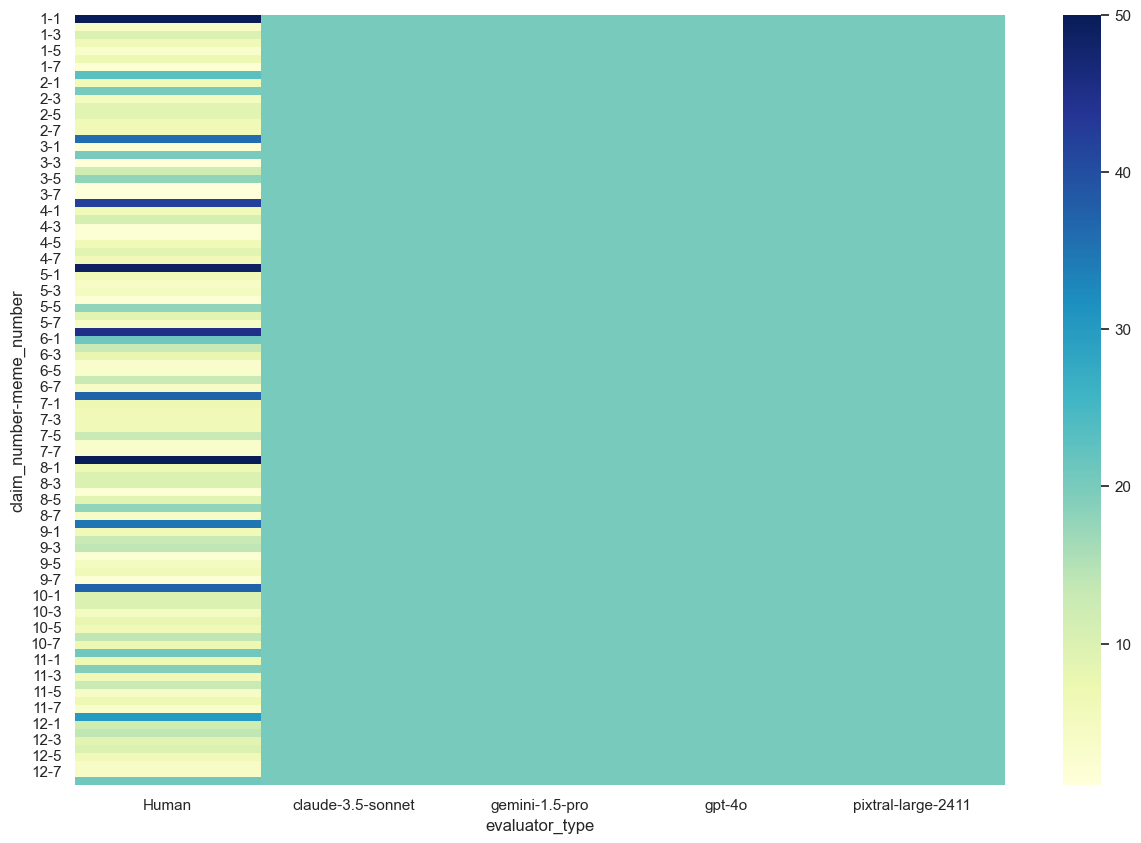

In [46]:
# Count and print the number of evaluations per claim-meme combination by evaluator type

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate  # If not installed, you can use alternative formatting

###############################
# 1. Prepare Human Ratings Data
###############################

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Create a set to track which claim-meme combinations this rater evaluated
    rated_combinations = set()
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add this claim-meme combination to the set
            rated_combinations.add((claim_num, meme_num))
    
    # Add each unique claim-meme combination to the transformed data
    for claim_num, meme_num in rated_combinations:
        human_transformed_data.append({
            'rater_id': rater_id,
            'claim_number': claim_num,
            'meme_number': meme_num,
            'evaluator_type': 'Human'
        })

# Create dataframe of human evaluations
df_human_evals = pd.DataFrame(human_transformed_data)

###############################
# 2. Prepare AI Ratings Data
###############################

# Extract unique evaluations from AI data (one evaluation = one model rating one meme)
ai_evaluations = []

for index, row in df_judge_processed.iterrows():
    ai_evaluations.append({
        'rater_id': f"{row['model_name_judge']}_{index}",
        'claim_number': row['claim_number'],
        'meme_number': row['meme_number'],
        'evaluator_type': row['model_name_judge'],
        'evaluation_mode': row['evaluation_mode']
    })

# Create dataframe of AI evaluations
df_ai_evals = pd.DataFrame(ai_evaluations)

###############################
# 3. Combine and Count Evaluations
###############################

# Add evaluation_mode to human data (for consistency when combining)
df_human_evals['evaluation_mode'] = 'human'

# Combine human and AI evaluations
all_evaluations = pd.concat([df_human_evals, df_ai_evals])

# Count evaluations by claim, meme, and evaluator type
eval_counts = all_evaluations.groupby(['claim_number', 'meme_number', 'evaluator_type']).size().reset_index(name='count')

# Pivot the data for easier reading
count_pivot = eval_counts.pivot_table(
    index=['claim_number', 'meme_number'], 
    columns='evaluator_type', 
    values='count',
    fill_value=0
)

# Reset index to convert back to a regular dataframe
count_pivot_reset = count_pivot.reset_index()

# Sort by claim number and meme number
count_pivot_reset = count_pivot_reset.sort_values(['claim_number', 'meme_number'])

###############################
# 4. Print Evaluation Counts
###############################

print("Number of Evaluations Per Claim-Meme Combination:")
print("================================================")

# If tabulate is available, use it for nice formatting
try:
    print(tabulate(count_pivot_reset, headers='keys', tablefmt='grid', showindex=False))
except:
    print(count_pivot_reset.to_string(index=False))

###############################
# 5. Calculate and Print Summary Statistics
###############################

print("\nSummary Statistics:")
print("==================")

# Total evaluations by evaluator type
total_by_type = eval_counts.groupby('evaluator_type')['count'].sum().reset_index()
total_by_type = total_by_type.sort_values('count', ascending=False)
print("\nTotal Evaluations by Evaluator Type:")
for _, row in total_by_type.iterrows():
    print(f"{row['evaluator_type']}: {row['count']} evaluations")

# Average evaluations per claim-meme combination
avg_by_type = eval_counts.groupby('evaluator_type')['count'].mean().reset_index()
avg_by_type = avg_by_type.sort_values('count', ascending=False)
print("\nAverage Evaluations per Claim-Meme Combination:")
for _, row in avg_by_type.iterrows():
    print(f"{row['evaluator_type']}: {row['count']:.2f} evaluations")

# Count of claim-meme combinations evaluated by each type
combinations_by_type = eval_counts.groupby('evaluator_type').size().reset_index(name='combinations')
combinations_by_type = combinations_by_type.sort_values('combinations', ascending=False)
print("\nNumber of Claim-Meme Combinations Evaluated:")
for _, row in combinations_by_type.iterrows():
    print(f"{row['evaluator_type']}: {row['combinations']} combinations")

###############################
# 6. AI Evaluation Counts by Mode
###############################

# Count evaluations by model and mode
mode_counts = df_ai_evals.groupby(['evaluator_type', 'evaluation_mode']).size().reset_index(name='count')
mode_pivot = mode_counts.pivot(index='evaluator_type', columns='evaluation_mode', values='count')
mode_pivot['total'] = mode_pivot.sum(axis=1)
mode_pivot = mode_pivot.sort_values('total', ascending=False)

print("\nAI Evaluations by Model and Mode:")
try:
    print(tabulate(mode_pivot.reset_index(), headers='keys', tablefmt='grid', showindex=False))
except:
    print(mode_pivot.to_string())

###############################
# 7. Additional Analysis: Coverage Completeness
###############################

# Calculate how many claim-meme combinations are evaluated by each evaluator type
total_combinations = len(all_evaluations[['claim_number', 'meme_number']].drop_duplicates())
print(f"\nTotal number of unique claim-meme combinations: {total_combinations}")

coverage = {}
for evaluator in all_evaluations['evaluator_type'].unique():
    evaluator_data = all_evaluations[all_evaluations['evaluator_type'] == evaluator]
    unique_combinations = len(evaluator_data[['claim_number', 'meme_number']].drop_duplicates())
    coverage[evaluator] = (unique_combinations / total_combinations) * 100

coverage_df = pd.DataFrame({'evaluator_type': list(coverage.keys()), 'coverage_percentage': list(coverage.values())})
coverage_df = coverage_df.sort_values('coverage_percentage', ascending=False)

print("\nCoverage of Claim-Meme Combinations:")
for _, row in coverage_df.iterrows():
    print(f"{row['evaluator_type']}: {row['coverage_percentage']:.2f}% of combinations")

###############################
# 8. Create a Heatmap of Evaluation Counts
###############################

# Create a heatmap to visualize evaluation counts
plt.figure(figsize=(15, 10))
heatmap_data = count_pivot.copy()

# Ensure all evaluator types are present (fill with 0 if missing)
all_evaluators = ['Human', 'claude-3.5-sonnet', 'gemini-1.5-pro', 'gpt-4o', 'pixtral-large-2411']
for evaluator in all_evaluators:
    if evaluator not in heatmap_data.columns:
        heatmap_data[evaluator] = 0

# Reorder columns to put Human first
col_order = ['Human'] + [col for col in heatmap_data.columns if col != 'Human']
heatmap_data = heatmap_data[col_order]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Number of Evaluations per Claim-Meme Combination by Evaluator Type', fontsize=16)
plt.tight_layout()
plt.savefig('evaluation_count_heatmap.png', dpi=300)
plt.close()

print("\nAnalysis complete! A heatmap visualization has also been saved as 'evaluation_count_heatmap.png'.")

In [57]:
# Improved analysis of agreement between AI and human ratings using QWK
# Following expert recommendations for ordinal data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

###############################
# 1. Transform Human Ratings Data
###############################

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add to transformed data
            human_transformed_data.append({
                'rater_id': rater_id,
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': human_dimensions[dimension],  # Use consistent dimension name
                'rating': int(row[col])  # Ensure ratings are integers
            })

# Create dataframe from transformed data
df_human_long = pd.DataFrame(human_transformed_data)

###############################
# 2. Count evaluations per meme
###############################

# Count number of human evaluations per claim-meme-dimension
human_counts = df_human_long.groupby(['claim_number', 'meme_number', 'dimension']).size().reset_index(name='count')

# Get list of claim-meme-dimension combinations with at least 10 human ratings
sufficient_ratings = human_counts[human_counts['count'] >= 7][['claim_number', 'meme_number', 'dimension']]
print(f"Filtering to {len(sufficient_ratings)} claim-meme-dimension combinations with at least 10 human ratings")

# Create a key column for merging
sufficient_ratings['key'] = sufficient_ratings['claim_number'].astype(str) + '_' + \
                            sufficient_ratings['meme_number'].astype(str) + '_' + \
                            sufficient_ratings['dimension']

###############################
# 3. Filter and aggregate human ratings
###############################

# Add key column to human data
df_human_long['key'] = df_human_long['claim_number'].astype(str) + '_' + \
                       df_human_long['meme_number'].astype(str) + '_' + \
                       df_human_long['dimension']

# Filter to only claim-meme-dimension with sufficient ratings
df_human_filtered = df_human_long[df_human_long['key'].isin(sufficient_ratings['key'])]

# Aggregate human ratings using median (recommended for ordinal data)
human_median = df_human_filtered.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].median().reset_index()
human_median = human_median.rename(columns={'rating': 'human_median'})

# Also calculate mean and mode for comparison
human_mean = df_human_filtered.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()
human_mean = human_mean.rename(columns={'rating': 'human_mean'})
human_mean['human_mean_rounded'] = human_mean['human_mean'].round().astype(int)

# Calculate mode (most common rating)
def get_mode(group):
    mode_values = group.mode()
    if len(mode_values) == 0:
        return np.nan
    return mode_values.iloc[0]

human_mode = df_human_filtered.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].apply(get_mode).reset_index()
human_mode = human_mode.rename(columns={'rating': 'human_mode'})

# Combine all aggregation methods
human_agg = pd.merge(human_median, human_mean, on=['claim_number', 'meme_number', 'dimension'])
human_agg = pd.merge(human_agg, human_mode, on=['claim_number', 'meme_number', 'dimension'])

###############################
# 4. Prepare AI ratings data
###############################

# Extract unique evaluations from AI data 
ai_ratings_list = []

for index, row in df_judge_processed.iterrows():
    claim_num = row['claim_number']
    meme_num = row['meme_number']
    model = row['model_name_judge']
    
    # Create key column for checking if this combination has sufficient human ratings
    for dim in ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']:
        key = f"{claim_num}_{meme_num}_{dim}"
        if pd.notna(row[dim]):
            ai_ratings_list.append({
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': dim,
                'model': model,
                'mode': row['evaluation_mode'],
                'rating': row[dim],
                'key': key
            })

# Create dataframe
df_ai_ratings = pd.DataFrame(ai_ratings_list)

# Filter to only include claim-meme-dimension combinations with sufficient human ratings
df_ai_filtered = df_ai_ratings[df_ai_ratings['key'].isin(sufficient_ratings['key'])]

# Aggregate AI ratings using median (for each model)
ai_median = df_ai_filtered.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].median().reset_index()
ai_median = ai_median.rename(columns={'rating': 'model_median'})

# Also calculate mean and mode
ai_mean = df_ai_filtered.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()
ai_mean = ai_mean.rename(columns={'rating': 'model_mean'})
ai_mean['model_mean_rounded'] = ai_mean['model_mean'].round().astype(int)

ai_mode = df_ai_filtered.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].apply(get_mode).reset_index()
ai_mode = ai_mode.rename(columns={'rating': 'model_mode'})

# Combine all aggregation methods
ai_agg = pd.merge(ai_median, ai_mean, on=['model', 'claim_number', 'meme_number', 'dimension'])
ai_agg = pd.merge(ai_agg, ai_mode, on=['model', 'claim_number', 'meme_number', 'dimension'])

###############################
# 5. Function to calculate Quadratic Weighted Kappa
###############################

def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    """
    Calculate quadratic weighted kappa
    
    Parameters:
    y_true (array-like): Ground truth (human) ratings
    y_pred (array-like): Predicted (AI) ratings
    min_rating (int): Minimum possible rating
    max_rating (int): Maximum possible rating
    
    Returns:
    float: Quadratic weighted kappa score
    """
    # Ensure all ratings are within range and are integers
    y_true = np.clip(y_true, min_rating, max_rating).astype(int)
    y_pred = np.clip(y_pred, min_rating, max_rating).astype(int)
    
    # Create confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, 
                               labels=list(range(min_rating, max_rating + 1)))
    
    # Create weight matrix (quadratic weights)
    num_ratings = max_rating - min_rating + 1
    weights = np.zeros((num_ratings, num_ratings))
    for i in range(num_ratings):
        for j in range(num_ratings):
            weights[i, j] = ((i - j) ** 2) / ((num_ratings - 1) ** 2)
    
    # Calculate expected and observed weighted agreement
    hist_true = np.bincount(y_true - min_rating, minlength=num_ratings)
    hist_pred = np.bincount(y_pred - min_rating, minlength=num_ratings)
    
    # Normalize histograms
    hist_true = hist_true / hist_true.sum()
    hist_pred = hist_pred / hist_pred.sum()
    
    # Compute expected confusion matrix
    expected = np.outer(hist_true, hist_pred)
    expected = expected * conf_mat.sum()
    
    # Calculate weighted observed and expected disagreement
    observed_weighted = (conf_mat * weights).sum()
    expected_weighted = (expected * weights).sum()
    
    # Calculate kappa
    if expected_weighted == 0:
        return 1.0  # Perfect agreement
    else:
        return 1 - (observed_weighted / expected_weighted)

###############################
# 6. Calculate QWK for each model and dimension (using median aggregation)
###############################

# Merge human and model ratings
qwk_results = []

for model_name in ai_agg['model'].unique():
    model_data = ai_agg[ai_agg['model'] == model_name]
    
    # Merge with human aggregated data
    merged = pd.merge(
        model_data,
        human_agg,
        on=['claim_number', 'meme_number', 'dimension']
    )
    
    # Calculate QWK for each dimension
    for dimension in merged['dimension'].unique():
        dim_data = merged[merged['dimension'] == dimension]
        
        # Calculate QWK using median (recommended for ordinal data)
        median_qwk = quadratic_weighted_kappa(
            dim_data['human_median'],
            dim_data['model_median']
        )
        
        # Calculate QWK using rounded mean
        mean_qwk = quadratic_weighted_kappa(
            dim_data['human_mean_rounded'],
            dim_data['model_mean_rounded']
        )
        
        # Calculate QWK using mode
        mode_qwk = quadratic_weighted_kappa(
            dim_data['human_mode'],
            dim_data['model_mode']
        )
        
        qwk_results.append({
            'model': model_name,
            'dimension': dimension,
            'qwk_median': median_qwk,
            'qwk_mean': mean_qwk,
            'qwk_mode': mode_qwk,
            'sample_size': len(dim_data)
        })

# Create dataframe
qwk_df = pd.DataFrame(qwk_results)

###############################
# 7. Calculate QWK by evaluation mode
###############################

# The exact same approach, but split by evaluation mode
mode_qwk_results = []

# For each mode
for mode in ['deterministic', 'creative']:
    # Filter AI data by mode
    mode_data = df_ai_filtered[df_ai_filtered['mode'] == mode]
    
    # Aggregate by model, claim, meme, dimension
    mode_median = mode_data.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].median().reset_index()
    mode_median = mode_median.rename(columns={'rating': 'model_median'})
    
    mode_mean = mode_data.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].mean().reset_index()
    mode_mean = mode_mean.rename(columns={'rating': 'model_mean'})
    mode_mean['model_mean_rounded'] = mode_mean['model_mean'].round().astype(int)
    
    mode_mode = mode_data.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].apply(get_mode).reset_index()
    mode_mode = mode_mode.rename(columns={'rating': 'model_mode'})
    
    # Combine
    mode_agg = pd.merge(mode_median, mode_mean, on=['model', 'claim_number', 'meme_number', 'dimension'])
    mode_agg = pd.merge(mode_agg, mode_mode, on=['model', 'claim_number', 'meme_number', 'dimension'])
    
    # For each model
    for model_name in mode_agg['model'].unique():
        model_mode_data = mode_agg[mode_agg['model'] == model_name]
        
        # Merge with human data
        merged = pd.merge(
            model_mode_data,
            human_agg,
            on=['claim_number', 'meme_number', 'dimension']
        )
        
        # Calculate QWK for each dimension
        for dimension in merged['dimension'].unique():
            dim_data = merged[merged['dimension'] == dimension]
            
            # Skip if too few samples
            if len(dim_data) < 5:
                continue
            
            # Calculate QWK using median
            median_qwk = quadratic_weighted_kappa(
                dim_data['human_median'],
                dim_data['model_median']
            )
            
            # Also calculate using mean and mode
            mean_qwk = quadratic_weighted_kappa(
                dim_data['human_mean_rounded'],
                dim_data['model_mean_rounded']
            )
            
            mode_qwk = quadratic_weighted_kappa(
                dim_data['human_mode'],
                dim_data['model_mode']
            )
            
            mode_qwk_results.append({
                'model': model_name,
                'dimension': dimension,
                'evaluation_mode': mode,
                'qwk_median': median_qwk,
                'qwk_mean': mean_qwk,
                'qwk_mode': mode_qwk,
                'sample_size': len(dim_data)
            })

# Create dataframe
mode_qwk_df = pd.DataFrame(mode_qwk_results)

###############################
# 8. Display plots
###############################

print("\nQuadratic Weighted Kappa Results by Model and Dimension (using median aggregation):")
pivot_median = qwk_df.pivot(index='model', columns='dimension', values='qwk_median')
print(pivot_median)

# Calculate overall average QWK by model
model_avg_qwk = qwk_df.groupby('model')['qwk_median'].mean().reset_index()
model_avg_qwk = model_avg_qwk.sort_values('qwk_median', ascending=False)

print("\nOverall Average QWK by Model (using median aggregation):")
for _, row in model_avg_qwk.iterrows():
    print(f"{row['model']}: {row['qwk_median']:.4f}")

# Compare different aggregation methods
agg_comparison = pd.DataFrame({
    'Median Aggregation': qwk_df.groupby('model')['qwk_median'].mean(),
    'Mean Aggregation': qwk_df.groupby('model')['qwk_mean'].mean(),
    'Mode Aggregation': qwk_df.groupby('model')['qwk_mode'].mean()
})

print("\nComparison of Aggregation Methods (Average QWK across all dimensions):")
print(agg_comparison.sort_values('Median Aggregation', ascending=False))

# Print mode comparison
print("\nQWK by Evaluation Mode (using median aggregation):")
mode_pivot = mode_qwk_df.pivot_table(
    index='model', 
    columns=['evaluation_mode', 'dimension'], 
    values='qwk_median'
)
print(mode_pivot)

# Average QWK by model and mode
mode_avg = mode_qwk_df.groupby(['model', 'evaluation_mode'])['qwk_median'].mean().reset_index()
mode_pivot_simple = mode_avg.pivot(index='model', columns='evaluation_mode', values='qwk_median')
mode_pivot_simple['difference'] = mode_pivot_simple['creative'] - mode_pivot_simple['deterministic']
print("\nAverage QWK by Model and Evaluation Mode:")
print(mode_pivot_simple.sort_values('deterministic', ascending=False))

###############################
# 9. Create visualizations
###############################

# 1. QWK by dimension for each model
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_median, annot=True, cmap='viridis', vmin=-1, vmax=1, center=0, fmt=".3f")
plt.title('Quadratic Weighted Kappa by Model and Dimension', fontsize=16)
plt.tight_layout()
plt.savefig('qwk_heatmap.png', dpi=300)
plt.close()

# 2. Average QWK by model
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='qwk_median', data=model_avg_qwk)
plt.title('Average Quadratic Weighted Kappa by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('QWK (Higher = Better Agreement)', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_qwk_by_model.png', dpi=300)
plt.close()

# 3. Comparison of aggregation methods
plt.figure(figsize=(12, 6))
agg_comparison.plot(kind='bar')
plt.title('Comparison of Different Aggregation Methods', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Average QWK', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.legend(title='Aggregation Method')
plt.tight_layout()
plt.savefig('aggregation_method_comparison.png', dpi=300)
plt.close()

# 4. Evaluation mode comparison
plt.figure(figsize=(10, 6))
mode_data_plot = mode_avg.pivot(index='model', columns='evaluation_mode', values='qwk_median')
mode_data_plot.plot(kind='bar')
plt.title('QWK by Model and Evaluation Mode', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Average QWK', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.legend(title='Evaluation Mode')
plt.tight_layout()
plt.savefig('qwk_by_evaluation_mode.png', dpi=300)
plt.close()

# 5. QWK by dimension
dimension_avg = qwk_df.groupby('dimension')['qwk_median'].mean().reset_index()
dimension_avg = dimension_avg.sort_values('qwk_median', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='dimension', y='qwk_median', data=dimension_avg)
plt.title('Average QWK by Rating Dimension', fontsize=16)
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('Average QWK', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('qwk_by_dimension.png', dpi=300)
plt.close()

print("\nAnalysis complete! Check the generated PNG files for visualizations.")

Filtering to 255 claim-meme-dimension combinations with at least 10 human ratings

Quadratic Weighted Kappa Results by Model and Dimension (using median aggregation):
dimension            clarity  coherence  hilarity  persuasiveness  \
model                                                               
claude-3.5-sonnet  -0.070304   0.162687  0.174286        0.040953   
gemini-1.5-pro      0.055556  -0.120423  0.114007        0.001224   
gpt-4o              0.082367   0.047380  0.133333        0.069437   
pixtral-large-2411  0.108941  -0.014589  0.413793        0.090489   

dimension           template_appropriateness  
model                                         
claude-3.5-sonnet                   0.064411  
gemini-1.5-pro                      0.030418  
gpt-4o                              0.038743  
pixtral-large-2411                  0.082902  

Overall Average QWK by Model (using median aggregation):
pixtral-large-2411: 0.1363
claude-3.5-sonnet: 0.0744
gpt-4o: 0.0743
gemini-1.5

<Figure size 1200x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [51]:
# Simple script to count human ratings for each meme-claim combination

import pandas as pd
import re
from collections import defaultdict

# Step 1: Count ratings for each claim-meme combination
claim_meme_ratings = defaultdict(int)

# Define pattern to extract claim and meme numbers from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_\w+')

# Loop through each column that contains meme ratings (not 'none' columns)
for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
    match = pattern.match(col)
    if match:
        claim_num = int(match.group(1))
        meme_num = int(match.group(2))
        
        # Count non-null values in this column
        ratings_count = df_human[col].notna().sum()
        
        # Update the count for this claim-meme combination
        key = (claim_num, meme_num)
        claim_meme_ratings[key] += ratings_count

# Convert to dataframe for easier display
ratings_df = pd.DataFrame([
    {'claim_number': claim, 'meme_number': meme, 'total_ratings': count}
    for (claim, meme), count in claim_meme_ratings.items()
])

# Sort by claim and meme numbers
ratings_df = ratings_df.sort_values(['claim_number', 'meme_number'])

# Print the ratings count for each combination
print("Human Ratings Count for Each Claim-Meme Combination:")
print("==================================================")
print(ratings_df.to_string(index=False))

# Count combinations with 10+ ratings
combinations_10plus = ratings_df[ratings_df['total_ratings'] >= 10]
total_combinations = len(ratings_df)
combinations_10plus_count = len(combinations_10plus)

print(f"\nOut of {total_combinations} total claim-meme combinations:")
print(f"- {combinations_10plus_count} combinations have 10 or more human ratings")
print(f"- {total_combinations - combinations_10plus_count} combinations have fewer than 10 human ratings")

# Calculate percentage
percentage = (combinations_10plus_count / total_combinations) * 100
print(f"\nPercentage of claim-meme combinations with 10+ ratings: {percentage:.1f}%")

Human Ratings Count for Each Claim-Meme Combination:
 claim_number  meme_number  total_ratings
            1            1            250
            1            2             20
            1            3             50
            1            4             30
            1            5             15
            1            6             35
            1            7             10
            1            8            115
            2            1             30
            2            2            100
            2            3             25
            2            4             45
            2            5             45
            2            6             30
            2            7             30
            2            8            180
            3            1             10
            3            2            100
            3            3              5
            3            4             60
            3            5             90
            3          

In [77]:
# Count unique human raters for each meme-claim combination

import pandas as pd
import re
import numpy as np

# Create a set to track which human has rated which claim-meme combination
rater_claim_meme_set = set()

# Create a dictionary to count unique raters per claim-meme combination
unique_raters_count = {}

# Define pattern to extract claim and meme numbers from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_\w+')

# Loop through each row (each human rater)
for rater_idx, row in df_human.iterrows():
    # Track which claim-meme combinations this rater has rated
    rater_combinations = set()
    
    # Check each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            
            # If this rating is not NaN, the rater has rated this combination
            if not pd.isna(row[col]):
                rater_combinations.add((claim_num, meme_num))
    
    # Add to the global tracking set and update counts
    for combo in rater_combinations:
        rater_claim_meme_set.add((rater_idx, combo[0], combo[1]))
        
        if combo not in unique_raters_count:
            unique_raters_count[combo] = 0
        unique_raters_count[combo] += 1

# Convert to dataframe for easier display
results = []
for (claim, meme), count in unique_raters_count.items():
    results.append({
        'claim_number': claim,
        'meme_number': meme,
        'unique_raters': count
    })

ratings_df = pd.DataFrame(results)

# Sort by claim and meme numbers
ratings_df = ratings_df.sort_values(['claim_number', 'meme_number'])

# Print the count of unique raters for each combination
print("Number of Unique Human Raters for Each Claim-Meme Combination:")
print("==========================================================")
print(ratings_df.to_string(index=False))

# Count combinations with 10+ unique raters
combinations_10plus = ratings_df[ratings_df['unique_raters'] >= 6]
total_combinations = len(ratings_df)
combinations_10plus_count = len(combinations_10plus)

print(f"\nOut of {total_combinations} total claim-meme combinations:")
print(f"- {combinations_10plus_count} combinations have 10 or more unique human raters")
print(f"- {total_combinations - combinations_10plus_count} combinations have fewer than 10 unique human raters")

# Calculate percentage
percentage = (combinations_10plus_count / total_combinations) * 100
print(f"\nPercentage of claim-meme combinations with 10+ unique raters: {percentage:.1f}%")

# Display distribution of unique rater counts
rater_distribution = ratings_df['unique_raters'].value_counts().sort_index()
print("\nDistribution of unique rater counts:")
for count, freq in rater_distribution.items():
    print(f"  {count} unique raters: {freq} combinations")

# Show average unique raters by meme number
meme_avg = ratings_df.groupby('meme_number')['unique_raters'].mean().reset_index()
meme_avg = meme_avg.sort_values('unique_raters', ascending=False)

print("\nAverage number of unique raters by meme number:")
for _, row in meme_avg.iterrows():
    print(f"  Meme #{int(row['meme_number'])}: {row['unique_raters']:.1f} unique raters on average")

Number of Unique Human Raters for Each Claim-Meme Combination:
 claim_number  meme_number  unique_raters
            1            1             50
            1            2              4
            1            3             10
            1            4              6
            1            5              3
            1            6              7
            1            7              2
            1            8             23
            2            1              6
            2            2             20
            2            3              5
            2            4              9
            2            5              9
            2            6              6
            2            7              6
            2            8             36
            3            1              2
            3            2             20
            3            3              1
            3            4             12
            3            5             18
            3

In [83]:
# Updated QWK analysis - filter for claim-meme combinations with 5+ human raters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

###############################
# 1. First, identify which claim-meme combinations have 5+ human raters
###############################

# Create a set to track which human has rated which claim-meme combination
rater_claim_meme_set = set()

# Create a dictionary to count unique raters per claim-meme combination
unique_raters_count = {}

# Define pattern to extract claim and meme numbers from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_\w+')

# Loop through each row (each human rater)
for rater_idx, row in df_human.iterrows():
    # Track which claim-meme combinations this rater has rated
    rater_combinations = set()
    
    # Check each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            
            # If this rating is not NaN, the rater has rated this combination
            if not pd.isna(row[col]):
                rater_combinations.add((claim_num, meme_num))
    
    # Add to the global tracking set and update counts
    for combo in rater_combinations:
        rater_claim_meme_set.add((rater_idx, combo[0], combo[1]))
        
        if combo not in unique_raters_count:
            unique_raters_count[combo] = 0
        unique_raters_count[combo] += 1

# Create a set of claim-meme combinations with 5+ unique raters
print(unique_raters_count)
valid_combinations = {combo for combo, count in unique_raters_count.items() if count >= 8}

print(f"Found {len(valid_combinations)} claim-meme combinations with 5+ unique human raters")

###############################
# 2. Transform Human Ratings Data
###############################

# Create empty lists to store transformed data
human_transformed_data = []

# Define rating dimensions
human_dimensions = {
    'coherence': 'coherence',
    'clarity': 'clarity', 
    'hilarity': 'hilarity',
    'persuasiveness': 'persuasiveness',
    'template_conveyance': 'template_appropriateness'  # Map to AI terminology
}

# Define pattern to extract claim, meme, and dimension from column names
pattern = re.compile(r'claim(\d+)_meme(\d+)_(\w+)')

# Loop through each rater
for idx, row in df_human.iterrows():
    rater_id = row.get('prolific_id', idx)  # Use prolific_id if available, otherwise use index
    
    # Loop through each column that contains meme ratings (not 'none' columns)
    for col in [c for c in df_human.columns if 'meme' in c and 'none' not in c]:
        match = pattern.match(col)
        if match:
            claim_num = int(match.group(1))
            meme_num = int(match.group(2))
            dimension = match.group(3)
            
            # Skip if the claim-meme combination doesn't have enough raters
            if (claim_num, meme_num) not in valid_combinations:
                continue
                
            # Skip if not one of our main dimensions
            if dimension not in human_dimensions:
                continue
                
            # Skip if the rating is missing
            if pd.isna(row[col]):
                continue
                
            # Add to transformed data
            human_transformed_data.append({
                'rater_id': rater_id,
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': human_dimensions[dimension],  # Use consistent dimension name
                'rating': int(row[col])  # Ensure ratings are integers
            })

# Create dataframe from transformed data
df_human_long = pd.DataFrame(human_transformed_data)

###############################
# 3. Aggregate human ratings using median
###############################

# Calculate median rating for each claim-meme-dimension
human_median = df_human_long.groupby(['claim_number', 'meme_number', 'dimension'])['rating'].median().reset_index()
human_median = human_median.rename(columns={'rating': 'human_median'})

# Create a key column for merging
human_median['key'] = human_median['claim_number'].astype(str) + '_' + \
                      human_median['meme_number'].astype(str) + '_' + \
                      human_median['dimension']

###############################
# 4. Prepare AI ratings data
###############################

# Extract ratings from AI data 
ai_ratings_list = []

for index, row in df_judge_processed.iterrows():
    claim_num = row['claim_number']
    meme_num = row['meme_number']
    model = row['model_name_judge']
    
    # Skip if the claim-meme combination doesn't have enough human raters
    if (claim_num, meme_num) not in valid_combinations:
        continue
    
    # Create key for each dimension
    for dim in ['coherence', 'clarity', 'hilarity', 'persuasiveness', 'template_appropriateness']:
        key = f"{claim_num}_{meme_num}_{dim}"
        if pd.notna(row[dim]):
            ai_ratings_list.append({
                'claim_number': claim_num,
                'meme_number': meme_num,
                'dimension': dim,
                'model': model,
                'mode': row['evaluation_mode'],
                'rating': row[dim],
                'key': key
            })

# Create dataframe
df_ai_ratings = pd.DataFrame(ai_ratings_list)

# Aggregate AI ratings using median for each model, claim, meme, dimension
ai_median = df_ai_ratings.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].median().reset_index()
ai_median = ai_median.rename(columns={'rating': 'model_median'})

# Create key column
ai_median['key'] = ai_median['claim_number'].astype(str) + '_' + \
                  ai_median['meme_number'].astype(str) + '_' + \
                  ai_median['dimension']

###############################
# 5. Function to calculate Quadratic Weighted Kappa with appropriate penalties
###############################

def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    """
    Calculate quadratic weighted kappa with appropriate penalties
    
    Parameters:
    y_true (array-like): Ground truth (human) ratings
    y_pred (array-like): Predicted (AI) ratings
    min_rating (int): Minimum possible rating
    max_rating (int): Maximum possible rating
    
    Returns:
    float: Quadratic weighted kappa score
    """
    # Ensure all ratings are within range and are integers
    y_true = np.clip(y_true, min_rating, max_rating).astype(int)
    y_pred = np.clip(y_pred, min_rating, max_rating).astype(int)
    
    # Create confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred, 
                               labels=list(range(min_rating, max_rating + 1)))
    
    # Create weight matrix with appropriate penalties
    # For a 1-5 scale, we want small penalty for 1-point difference,
    # and increasingly larger penalties for 2+ point differences
    num_ratings = max_rating - min_rating + 1
    weights = np.zeros((num_ratings, num_ratings))
    for i in range(num_ratings):
        for j in range(num_ratings):
            # Use squared difference divided by max possible squared difference
            # This ensures a small penalty for 1-point difference
            weights[i, j] = ((i - j) ** 2) / ((num_ratings - 1) ** 2)
    
    # Calculate expected and observed weighted agreement
    hist_true = np.bincount(y_true - min_rating, minlength=num_ratings)
    hist_pred = np.bincount(y_pred - min_rating, minlength=num_ratings)
    
    # Normalize histograms
    hist_true = hist_true / hist_true.sum()
    hist_pred = hist_pred / hist_pred.sum()
    
    # Compute expected confusion matrix
    expected = np.outer(hist_true, hist_pred)
    expected = expected * conf_mat.sum()
    
    # Calculate weighted observed and expected disagreement
    observed_weighted = (conf_mat * weights).sum()
    expected_weighted = (expected * weights).sum()
    
    # Calculate kappa
    if expected_weighted == 0:
        return 1.0  # Perfect agreement
    else:
        return 1 - (observed_weighted / expected_weighted)

###############################
# 6. Calculate QWK for each model and dimension using median aggregation
###############################

# Merge human and model ratings
qwk_results = []

for model_name in ai_median['model'].unique():
    model_data = ai_median[ai_median['model'] == model_name]
    
    # Merge with human aggregated data
    merged = pd.merge(
        model_data,
        human_median,
        on=['claim_number', 'meme_number', 'dimension']
    )
    
    # Calculate QWK for each dimension
    for dimension in merged['dimension'].unique():
        dim_data = merged[merged['dimension'] == dimension]
        
        # Calculate QWK using median
        median_qwk = quadratic_weighted_kappa(
            dim_data['human_median'],
            dim_data['model_median']
        )
        
        qwk_results.append({
            'model': model_name,
            'dimension': dimension,
            'qwk': median_qwk,
            'sample_size': len(dim_data)
        })

# Create dataframe
qwk_df = pd.DataFrame(qwk_results)

###############################
# 7. Calculate QWK by evaluation mode
###############################

# Filter AI data by mode and calculate QWK
mode_qwk_results = []

# For each mode
for mode in ['deterministic', 'creative']:
    # Filter AI data by mode
    mode_data = df_ai_ratings[df_ai_ratings['mode'] == mode]
    
    # Aggregate by model, claim, meme, dimension
    mode_median = mode_data.groupby(['model', 'claim_number', 'meme_number', 'dimension'])['rating'].median().reset_index()
    mode_median = mode_median.rename(columns={'rating': 'model_median'})
    
    # For each model
    for model_name in mode_median['model'].unique():
        model_mode_data = mode_median[mode_median['model'] == model_name]
        
        # Merge with human data
        merged = pd.merge(
            model_mode_data,
            human_median,
            on=['claim_number', 'meme_number', 'dimension']
        )
        
        # Calculate QWK for each dimension
        for dimension in merged['dimension'].unique():
            dim_data = merged[merged['dimension'] == dimension]
            
            # Skip if too few samples
            if len(dim_data) < 5:
                continue
            
            # Calculate QWK using median
            median_qwk = quadratic_weighted_kappa(
                dim_data['human_median'],
                dim_data['model_median']
            )
            
            mode_qwk_results.append({
                'model': model_name,
                'dimension': dimension,
                'evaluation_mode': mode,
                'qwk': median_qwk,
                'sample_size': len(dim_data)
            })

# Create dataframe
mode_qwk_df = pd.DataFrame(mode_qwk_results)

###############################
# 8. Display plots
###############################

print("\nQuadratic Weighted Kappa Results by Model and Dimension (using median aggregation):")
pivot_median = qwk_df.pivot(index='model', columns='dimension', values='qwk')
print(pivot_median)

# Calculate overall average QWK by model
model_avg_qwk = qwk_df.groupby('model')['qwk'].mean().reset_index()
model_avg_qwk = model_avg_qwk.sort_values('qwk', ascending=False)

print("\nOverall Average QWK by Model (using median aggregation):")
for _, row in model_avg_qwk.iterrows():
    print(f"{row['model']}: {row['qwk']:.4f}")

# Print mode comparison
print("\nQWK by Evaluation Mode (using median aggregation):")
mode_pivot = mode_qwk_df.pivot_table(
    index='model', 
    columns=['evaluation_mode', 'dimension'], 
    values='qwk'
)
print(mode_pivot)

# Average QWK by model and mode
mode_avg = mode_qwk_df.groupby(['model', 'evaluation_mode'])['qwk'].mean().reset_index()
mode_pivot_simple = mode_avg.pivot(index='model', columns='evaluation_mode', values='qwk')
mode_pivot_simple['difference'] = mode_pivot_simple['creative'] - mode_pivot_simple['deterministic']
print("\nAverage QWK by Model and Evaluation Mode:")
print(mode_pivot_simple.sort_values('deterministic', ascending=False))

###############################
# 9. Create visualizations
###############################

# 1. QWK by dimension for each model
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_median, annot=True, cmap='viridis', vmin=-1, vmax=1, center=0, fmt=".3f")
plt.title('Quadratic Weighted Kappa by Model and Dimension', fontsize=16)
plt.tight_layout()
plt.savefig('qwk_heatmap.png', dpi=300)
plt.close()

# 2. Average QWK by model
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='qwk', data=model_avg_qwk)
plt.title('Average Quadratic Weighted Kappa by Model', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('QWK (Higher = Better Agreement)', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add reference line at 0
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_qwk_by_model.png', dpi=300)
plt.close()

# 3. Evaluation mode comparison
plt.figure(figsize=(10, 6))
mode_data_plot = mode_avg.pivot(index='model', columns='evaluation_mode', values='qwk')
mode_data_plot.plot(kind='bar')
plt.title('QWK by Model and Evaluation Mode', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Average QWK', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.legend(title='Evaluation Mode')
plt.tight_layout()
plt.savefig('qwk_by_evaluation_mode.png', dpi=300)
plt.close()

# 4. QWK by dimension
dimension_avg = qwk_df.groupby('dimension')['qwk'].mean().reset_index()
dimension_avg = dimension_avg.sort_values('qwk', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='dimension', y='qwk', data=dimension_avg)
plt.title('Average QWK by Rating Dimension', fontsize=16)
plt.xlabel('Dimension', fontsize=14)
plt.ylabel('Average QWK', fontsize=14)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('qwk_by_dimension.png', dpi=300)
plt.close()

print("\nAnalysis complete! Check the generated PNG files for visualizations.")

{(12, 4): 10, (8, 4): 2, (3, 4): 12, (1, 8): 23, (9, 2): 13, (11, 6): 7, (4, 5): 6, (6, 3): 8, (10, 3): 5, (7, 5): 13, (2, 5): 9, (5, 2): 4, (7, 4): 6, (12, 1): 12, (2, 1): 6, (10, 7): 7, (4, 2): 11, (8, 3): 10, (5, 6): 9, (6, 6): 13, (3, 2): 20, (9, 1): 6, (1, 3): 10, (11, 4): 13, (10, 8): 21, (5, 8): 45, (1, 1): 50, (6, 8): 37, (9, 8): 37, (4, 8): 49, (7, 8): 50, (8, 6): 18, (11, 8): 30, (12, 8): 21, (3, 5): 18, (2, 8): 36, (8, 8): 35, (3, 8): 42, (6, 2): 13, (4, 6): 9, (9, 6): 6, (11, 7): 3, (3, 7): 1, (10, 4): 8, (5, 7): 4, (8, 5): 9, (9, 5): 5, (12, 5): 6, (4, 7): 6, (5, 1): 6, (11, 2): 19, (5, 5): 18, (1, 2): 4, (12, 7): 4, (2, 2): 20, (10, 5): 6, (6, 1): 21, (12, 3): 9, (9, 3): 14, (11, 3): 6, (10, 6): 14, (7, 6): 3, (7, 1): 7, (6, 5): 3, (1, 5): 3, (4, 1): 6, (5, 3): 5, (11, 1): 7, (12, 6): 4, (1, 6): 7, (10, 2): 10, (2, 6): 6, (2, 7): 6, (12, 2): 14, (2, 4): 9, (6, 4): 3, (1, 4): 6, (7, 2): 6, (5, 4): 2, (11, 5): 4, (4, 4): 2, (7, 7): 3, (8, 1): 7, (2, 3): 5, (10, 1): 10, (7, 

<Figure size 1000x600 with 0 Axes>

# Corr coherence human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human coherence ratings (first 5 rows):
        meme_id  coherence_human  n_human
0  claim1_meme1         4.360000       50
1  claim1_meme3         4.100000       10
2  claim1_meme8         4.217391       23
3  claim2_meme2         3.650000       20
4  claim2_meme8         3.611111       36
DEBUG: Total memes aggregated from human coherence ratings: 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI coherence ratings (first 5 rows):
         meme_id  coherence_ai
0  claim10_meme1        4.4625
1  claim10_meme2        4.3500
2  claim10_meme3        4.2500
3  claim10_meme4        4.1625
4  claim10_meme5        4.2750
DEBUG: Total memes aggregated from AI coherence ratings: 96

DEBUG: Merged data shape (human and AI coherence): (37, 4)
DEBUG: Merged sample:
        meme_id  coherence_human  n_human  coherence_ai
0  claim1_meme1         4.360000       50        4.5750
1  claim1_meme3         4.100000       10     

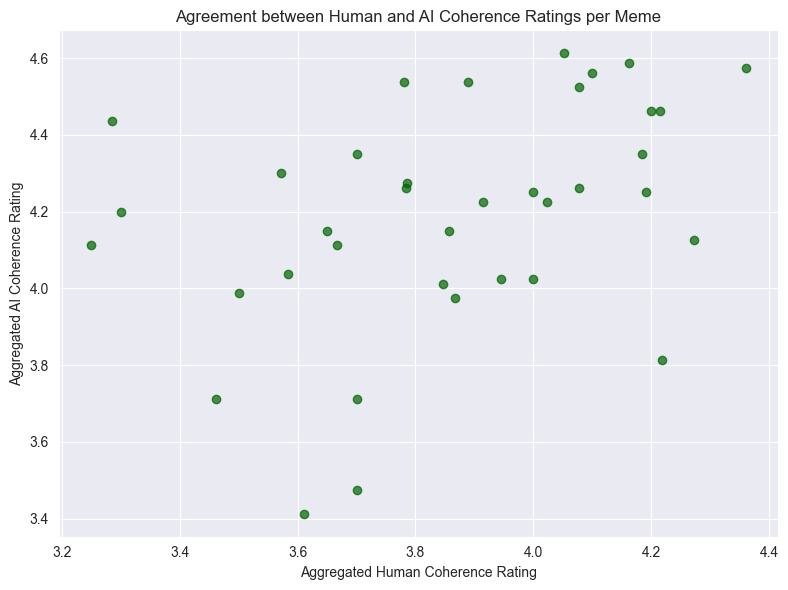

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Coherence Ratings
##############################################
def aggregate_human_coherence(df_human, min_evals):
    """
    For each meme in the human data, extract the 'coherence' ratings (from a column named "claimX_memeY_coherence")
    and, if there are at least 'min_evals' ratings, compute the average coherence for that meme.
    
    Returns a DataFrame with columns: 'meme_id', 'coherence_human', and 'n_human'.
    """
    human_list = []
    for claim in range(1, 13):           # claims 1 to 12
        for meme in range(1, 9):         # memes 1 to 8 per claim
            col = f"claim{claim}_meme{meme}_coherence"
            if col not in df_human.columns:
                continue
            # Convert the column to numeric (if not already) and drop NaN values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if len(ratings) < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({"meme_id": meme_id,
                               "coherence_human": avg_rating,
                               "n_human": len(ratings)})
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

# Set the minimum number of evaluations required per meme.
min_threshold = 10

# Aggregate human coherence ratings.
df_human_coherence = aggregate_human_coherence(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human coherence ratings (first 5 rows):")
print(df_human_coherence.head())
print(f"DEBUG: Total memes aggregated from human coherence ratings: {df_human_coherence.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Coherence)
##############################################
ai_path = "../llm_judge/plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (if needed).
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI 'coherence' metric from a string like "4/5" to numeric.
df_ai['coherence'] = df_ai['coherence'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human data format ("claimX_memeY").
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI coherence ratings per meme (average over all evaluations for that meme).
df_ai_agg = df_ai.groupby("meme_id")["coherence"].mean().reset_index()
df_ai_agg.rename(columns={'coherence': 'coherence_ai'}, inplace=True)
print("DEBUG: Aggregated AI coherence ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI coherence ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Coherence Ratings and Compute Agreement
##############################################
df_merge = pd.merge(df_human_coherence, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (human and AI coherence):", df_merge.shape)
print("DEBUG: Merged sample:")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    r, p_val = pearsonr(df_merge['coherence_human'], df_merge['coherence_ai'])
    print(f"Pearson correlation for coherence ratings (Human vs. AI): r = {r:.3f}, p = {p_val:.3e}")
else:
    print("No overlapping memes found between human and AI for coherence!")

##############################################
# Phase 4: Plot the Agreement for Coherence Ratings and Save the Plot
##############################################
plt.figure(figsize=(8,6))
plt.scatter(df_merge['coherence_human'], df_merge['coherence_ai'], color='darkgreen', alpha=0.7)
plt.xlabel("Aggregated Human Coherence Rating")
plt.ylabel("Aggregated AI Coherence Rating")
plt.title("Agreement between Human and AI Coherence Ratings per Meme")
plt.grid(True)
plt.tight_layout()

# Save the plot to the output directory.
output_dir = "../new_results"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "coherence_agreement.png")
plt.savefig(output_file)
print(f"DEBUG: Coherence agreement plot saved to {output_file}")
plt.show()


# Altman analysis human vs ai evals coherence

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human coherence ratings (first 5 rows):
        meme_id  coherence_human  n_human
0  claim1_meme1         4.360000       50
1  claim1_meme3         4.100000       10
2  claim1_meme8         4.217391       23
3  claim2_meme2         3.650000       20
4  claim2_meme8         3.611111       36
DEBUG: Total memes aggregated from human coherence ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI coherence ratings (first 5 rows):
         meme_id  coherence_ai
0  claim10_meme1        4.4625
1  claim10_meme2        4.3500
2  claim10_meme3        4.2500
3  claim10_meme4        4.1625
4  claim10_meme5        4.2750
DEBUG: Total memes aggregated from AI coherence ratings: 96

DEBUG: Merged data shape (for coherence): (37, 4)
DEBUG: Merged sample:
        meme_id  coherence_human  n_human  coherence_ai
0  claim1_meme1         4.360000       50        4.5750
1  claim1_meme3         4.100000       10    

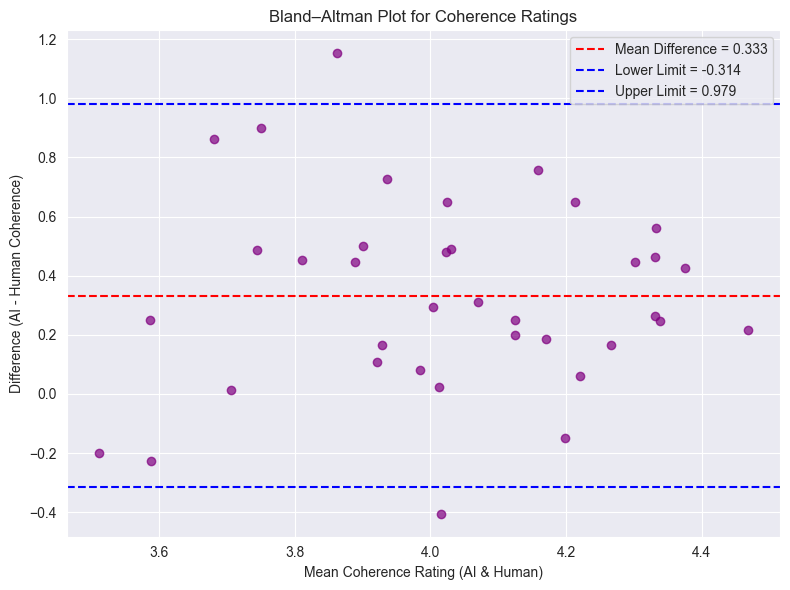

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Coherence Ratings
##############################################
def aggregate_human_coherence(df_human, min_evals):
    """
    For each meme in df_human (each combination of claim 1–12 and meme 1–8),
    if there are at least min_evals non-missing coherence ratings (from a column named
    "claimX_memeY_coherence"), compute the average coherence for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - coherence_human (the aggregated human coherence rating)
      - n_human (the number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_coherence"
            if col not in df_human.columns:
                continue
            # Convert the column values to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({"meme_id": meme_id,
                               "coherence_human": avg_rating,
                               "n_human": ratings.shape[0]})
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Coherence)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

# Choose a minimum threshold for human evaluations (e.g., 10)
min_threshold = 10
df_human_coh = aggregate_human_coherence(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human coherence ratings (first 5 rows):")
print(df_human_coh.head())
print(f"DEBUG: Total memes aggregated from human coherence ratings (n >= {min_threshold}): {df_human_coh.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Coherence)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (we’re pooling across all AI evaluations)
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI coherence metric from strings like "4/5" to numeric values.
df_ai['coherence'] = df_ai['coherence'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human data: "claimX_memeY"
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI coherence ratings per meme (averaging over all evaluations for that meme).
df_ai_agg = df_ai.groupby("meme_id")["coherence"].mean().reset_index()
df_ai_agg.rename(columns={'coherence': 'coherence_ai'}, inplace=True)
print("DEBUG: Aggregated AI coherence ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI coherence ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Coherence Ratings and Perform Bland–Altman Analysis
##############################################
df_merge = pd.merge(df_human_coh, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for coherence):", df_merge.shape)
print("DEBUG: Merged sample:")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    # For each overlapping meme, calculate:
    #  - the difference: AI coherence - Human coherence
    #  - the mean of the two coherence ratings
    df_merge['difference'] = df_merge['coherence_ai'] - df_merge['coherence_human']
    df_merge['mean_coherence'] = (df_merge['coherence_ai'] + df_merge['coherence_human']) / 2

    bias = df_merge['difference'].mean()
    sd_diff = df_merge['difference'].std()
    lower_limit = bias - 1.96 * sd_diff
    upper_limit = bias + 1.96 * sd_diff

    print("Bland–Altman Analysis Results for Coherence:")
    print(f"  Mean difference (bias): {bias:.3f}")
    print(f"  Standard deviation of differences: {sd_diff:.3f}")
    print(f"  Lower limit of agreement: {lower_limit:.3f}")
    print(f"  Upper limit of agreement: {upper_limit:.3f}\n")
    
    ##############################################
    # Phase 4: Plot the Bland–Altman Plot for Coherence and Save It
    ##############################################
    plt.figure(figsize=(8, 6))
    plt.scatter(df_merge['mean_coherence'], df_merge['difference'], color='purple', alpha=0.7)
    plt.axhline(bias, color='red', linestyle='--', label=f"Mean Difference = {bias:.3f}")
    plt.axhline(lower_limit, color='blue', linestyle='--', label=f"Lower Limit = {lower_limit:.3f}")
    plt.axhline(upper_limit, color='blue', linestyle='--', label=f"Upper Limit = {upper_limit:.3f}")
    plt.xlabel("Mean Coherence Rating (AI & Human)")
    plt.ylabel("Difference (AI - Human Coherence)")
    plt.title("Bland–Altman Plot for Coherence Ratings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    output_dir = "../new_results"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "bland_altman_coherence.png")
    plt.savefig(output_file)
    print(f"DEBUG: Coherence Bland–Altman plot saved to {output_file}\n")
    plt.show()
else:
    print("No overlapping memes found between human and AI for coherence!")

# Corr clarity human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human clarity ratings (first 5 rows):
        meme_id  clarity_human  n_human
0  claim1_meme1       4.400000       50
1  claim1_meme3       4.100000       10
2  claim1_meme8       4.217391       23
3  claim2_meme2       4.000000       20
4  claim2_meme8       3.888889       36
DEBUG: Total memes aggregated from human clarity ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI clarity ratings (first 5 rows):
         meme_id  clarity_ai
0  claim10_meme1      4.7750
1  claim10_meme2      4.7375
2  claim10_meme3      4.5500
3  claim10_meme4      4.2500
4  claim10_meme5      4.4875
DEBUG: Total memes aggregated from AI clarity ratings: 96

DEBUG: Merged data shape (for clarity): (37, 4)
DEBUG: Merged sample:
        meme_id  clarity_human  n_human  clarity_ai
0  claim1_meme1       4.400000       50      4.6375
1  claim1_meme3       4.100000       10      4.5125
2  claim1_meme8       4.217391     

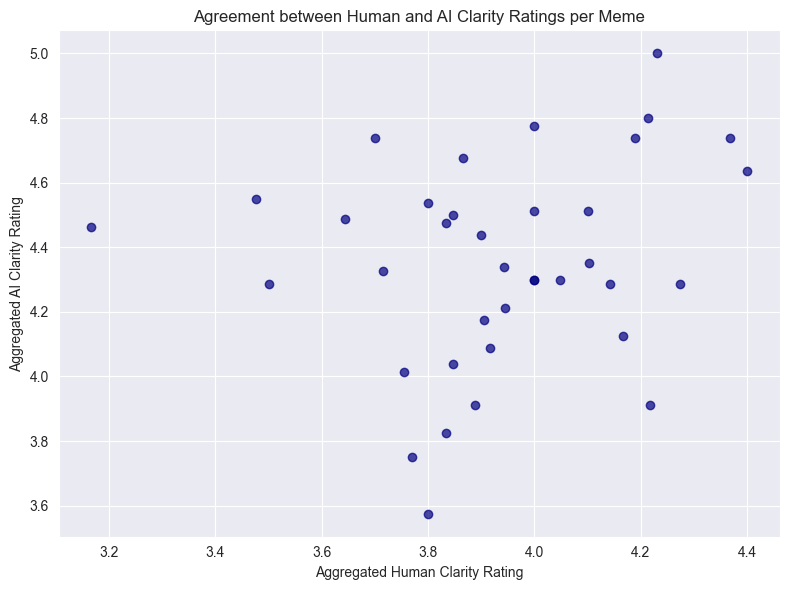

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Clarity Ratings
##############################################
def aggregate_human_clarity(df_human, min_evals):
    """
    For each meme in df_human (each combination of claim 1–12 and meme 1–8),
    if there are at least min_evals non-missing clarity ratings (from the column
    "claimX_memeY_clarity"), compute the average clarity for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - clarity_human (the aggregated human clarity rating)
      - n_human (the number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_clarity"
            if col not in df_human.columns:
                continue
            # Convert to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "clarity_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Clarity)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10   # Set the minimum number of evaluations required per meme.
df_human_clarity = aggregate_human_clarity(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human clarity ratings (first 5 rows):")
print(df_human_clarity.head())
print(f"DEBUG: Total memes aggregated from human clarity ratings (n >= {min_threshold}): {df_human_clarity.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Clarity)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (if needed).
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI 'clarity' metric from strings like "4/5" to numeric values.
df_ai['clarity'] = df_ai['clarity'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human data format: "claimX_memeY"
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate the AI clarity ratings per meme (average over all evaluations for that meme).
df_ai_agg = df_ai.groupby("meme_id")["clarity"].mean().reset_index()
df_ai_agg.rename(columns={'clarity': 'clarity_ai'}, inplace=True)
print("DEBUG: Aggregated AI clarity ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI clarity ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Clarity Ratings and Compute Pearson Correlation
##############################################
df_merge = pd.merge(df_human_clarity, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for clarity):", df_merge.shape)
print("DEBUG: Merged sample:")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    r, p_val = pearsonr(df_merge['clarity_human'], df_merge['clarity_ai'])
    print(f"Pearson correlation for clarity ratings (Human vs. AI): r = {r:.3f}, p = {p_val:.3e}")
else:
    print("No overlapping memes found between human and AI for clarity!")

##############################################
# Phase 4: Plot the Agreement for Clarity Ratings and Save the Plot
##############################################
plt.figure(figsize=(8, 6))
plt.scatter(df_merge['clarity_human'], df_merge['clarity_ai'], color='navy', alpha=0.7)
plt.xlabel("Aggregated Human Clarity Rating")
plt.ylabel("Aggregated AI Clarity Rating")
plt.title("Agreement between Human and AI Clarity Ratings per Meme")
plt.grid(True)
plt.tight_layout()

output_dir = "../new_results"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "clarity_agreement.png")
plt.savefig(output_file)
print(f"DEBUG: Clarity agreement plot saved to {output_file}")
plt.show()

# Altman clarity human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human clarity ratings (first 5 rows):
        meme_id  clarity_human  n_human
0  claim1_meme1       4.400000       50
1  claim1_meme3       4.100000       10
2  claim1_meme8       4.217391       23
3  claim2_meme2       4.000000       20
4  claim2_meme8       3.888889       36
DEBUG: Total memes aggregated from human clarity ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI clarity ratings (first 5 rows):
         meme_id  clarity_ai
0  claim10_meme1      4.7750
1  claim10_meme2      4.7375
2  claim10_meme3      4.5500
3  claim10_meme4      4.2500
4  claim10_meme5      4.4875
DEBUG: Total memes aggregated from AI clarity ratings: 96

DEBUG: Merged data shape (for clarity): (37, 4)
DEBUG: Merged sample (first 5 rows):
        meme_id  clarity_human  n_human  clarity_ai
0  claim1_meme1       4.400000       50      4.6375
1  claim1_meme3       4.100000       10      4.5125
2  claim1_meme8     

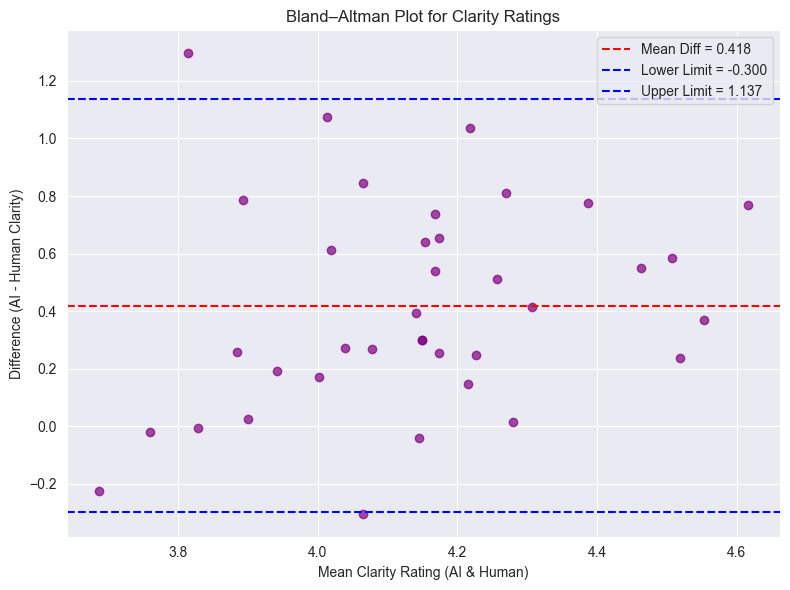

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Clarity Ratings
##############################################
def aggregate_human_clarity(df_human, min_evals):
    """
    For each meme in df_human (each combination of claim 1–12 and meme 1–8),
    if there are at least min_evals non-missing clarity ratings (from the column
    "claimX_memeY_clarity"), compute the average clarity for that meme.
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - clarity_human (the aggregated human clarity rating)
      - n_human (number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_clarity"
            if col not in df_human.columns:
                continue
            # Convert values to numeric and drop missing.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "clarity_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Clarity)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10  # set minimum number of evaluations required per meme
df_human_clarity = aggregate_human_clarity(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human clarity ratings (first 5 rows):")
print(df_human_clarity.head())
print(f"DEBUG: Total memes aggregated from human clarity ratings (n >= {min_threshold}): {df_human_clarity.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Clarity)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI clarity metric from strings like "4/5" to numeric.
df_ai['clarity'] = df_ai['clarity'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human format ("claimX_memeY").
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI clarity ratings per meme (averaging over all evaluations).
df_ai_agg = df_ai.groupby("meme_id")["clarity"].mean().reset_index()
df_ai_agg.rename(columns={'clarity': 'clarity_ai'}, inplace=True)
print("DEBUG: Aggregated AI clarity ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI clarity ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Clarity Data and Compute Bland–Altman Statistics
##############################################
df_merge = pd.merge(df_human_clarity, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for clarity):", df_merge.shape)
print("DEBUG: Merged sample (first 5 rows):")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    # Compute the difference (AI clarity - Human clarity) and the mean clarity for each meme.
    df_merge['difference'] = df_merge['clarity_ai'] - df_merge['clarity_human']
    df_merge['mean_clarity'] = (df_merge['clarity_ai'] + df_merge['clarity_human']) / 2

    # Compute Bland–Altman statistics.
    bias = df_merge['difference'].mean()
    sd_diff = df_merge['difference'].std()
    lower_limit = bias - 1.96 * sd_diff
    upper_limit = bias + 1.96 * sd_diff

    print("Bland–Altman Analysis Results for Clarity:")
    print(f"  Mean difference (bias): {bias:.3f}")
    print(f"  Standard deviation of differences: {sd_diff:.3f}")
    print(f"  Lower limit of agreement: {lower_limit:.3f}")
    print(f"  Upper limit of agreement: {upper_limit:.3f}\n")
    
    ##############################################
    # Phase 4: Plot the Bland–Altman Plot for Clarity and Save the Plot
    ##############################################
    plt.figure(figsize=(8, 6))
    plt.scatter(df_merge['mean_clarity'], df_merge['difference'], color='purple', alpha=0.7)
    plt.axhline(bias, color='red', linestyle='--', label=f"Mean Diff = {bias:.3f}")
    plt.axhline(lower_limit, color='blue', linestyle='--', label=f"Lower Limit = {lower_limit:.3f}")
    plt.axhline(upper_limit, color='blue', linestyle='--', label=f"Upper Limit = {upper_limit:.3f}")
    plt.xlabel("Mean Clarity Rating (AI & Human)")
    plt.ylabel("Difference (AI - Human Clarity)")
    plt.title("Bland–Altman Plot for Clarity Ratings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_dir = "../new_results"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "bland_altman_clarity.png")
    plt.savefig(output_file)
    print(f"DEBUG: Clarity Bland–Altman plot saved to {output_file}\n")
    plt.show()
else:
    print("No overlapping memes found between human and AI for clarity!")

# Corr hilarity human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human hilarity ratings (first 5 rows):
        meme_id  hilarity_human  n_human
0  claim1_meme1        3.760000       50
1  claim1_meme3        4.000000       10
2  claim1_meme8        4.086957       23
3  claim2_meme2        2.950000       20
4  claim2_meme8        3.583333       36
DEBUG: Total memes aggregated from human hilarity ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI hilarity ratings (first 5 rows):
         meme_id  hilarity_ai
0  claim10_meme1       4.0875
1  claim10_meme2       4.0125
2  claim10_meme3       4.1375
3  claim10_meme4       3.9750
4  claim10_meme5       4.0625
DEBUG: Total memes aggregated from AI hilarity ratings: 96

DEBUG: Merged data shape (for hilarity): (37, 4)
DEBUG: Merged sample:
        meme_id  hilarity_human  n_human  hilarity_ai
0  claim1_meme1        3.760000       50       3.9125
1  claim1_meme3        4.000000       10       4.0875
2  claim1_me

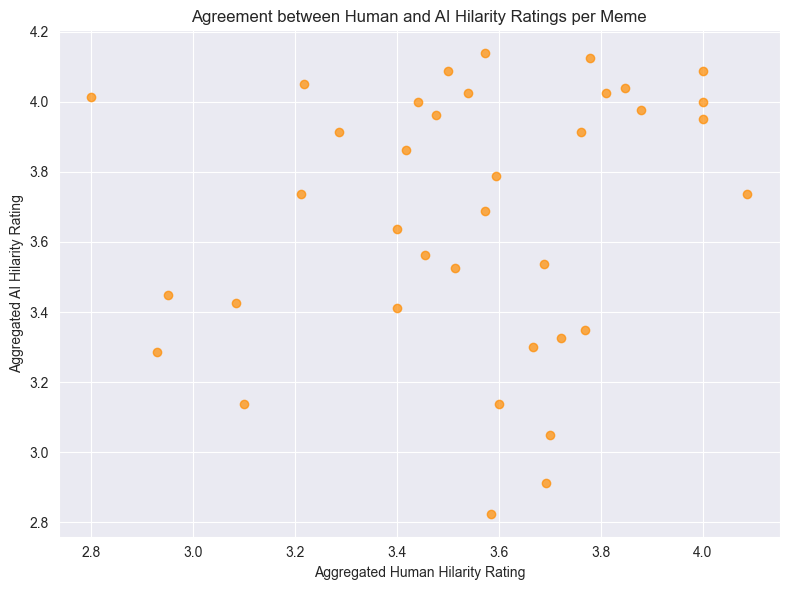

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Hilarity Ratings
##############################################
def aggregate_human_hilarity(df_human, min_evals):
    """
    For each meme in df_human (each combination of claim 1–12 and meme 1–8),
    if there are at least min_evals non-missing hilarity ratings (from the column
    "claimX_memeY_hilarity"), compute the average hilarity for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - hilarity_human (the aggregated human hilarity rating)
      - n_human (the number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_hilarity"
            if col not in df_human.columns:
                continue
            # Convert the column to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "hilarity_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Hilarity)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

# Set a minimum threshold of human evaluations per meme.
min_threshold = 10
df_human_hilarity = aggregate_human_hilarity(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human hilarity ratings (first 5 rows):")
print(df_human_hilarity.head())
print(f"DEBUG: Total memes aggregated from human hilarity ratings (n >= {min_threshold}): {df_human_hilarity.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Hilarity)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase.
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI 'hilarity' metric from strings like "4/5" to numeric values.
df_ai['hilarity'] = df_ai['hilarity'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human data format ("claimX_memeY").
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI hilarity ratings per meme (average over all evaluations for that meme).
df_ai_agg = df_ai.groupby("meme_id")["hilarity"].mean().reset_index()
df_ai_agg.rename(columns={'hilarity': 'hilarity_ai'}, inplace=True)
print("DEBUG: Aggregated AI hilarity ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI hilarity ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Hilarity Ratings and Compute Pearson Correlation
##############################################
df_merge = pd.merge(df_human_hilarity, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for hilarity):", df_merge.shape)
print("DEBUG: Merged sample:")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    r, p_val = pearsonr(df_merge['hilarity_human'], df_merge['hilarity_ai'])
    print(f"Pearson correlation for hilarity ratings (Human vs. AI): r = {r:.3f}, p = {p_val:.3e}")
else:
    print("No overlapping memes found between human and AI for hilarity!")

##############################################
# Phase 4: Plot the Agreement for Hilarity Ratings and Save the Plot
##############################################
plt.figure(figsize=(8, 6))
plt.scatter(df_merge['hilarity_human'], df_merge['hilarity_ai'], color='darkorange', alpha=0.7)
plt.xlabel("Aggregated Human Hilarity Rating")
plt.ylabel("Aggregated AI Hilarity Rating")
plt.title("Agreement between Human and AI Hilarity Ratings per Meme")
plt.grid(True)
plt.tight_layout()

output_dir = "../new_results"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "hilarity_agreement.png")
plt.savefig(output_file)
print(f"DEBUG: Hilarity agreement plot saved to {output_file}")
plt.show()

# Altman analysis hilarity human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human hilarity ratings (first 5 rows):
        meme_id  hilarity_human  n_human
0  claim1_meme1        3.760000       50
1  claim1_meme3        4.000000       10
2  claim1_meme8        4.086957       23
3  claim2_meme2        2.950000       20
4  claim2_meme8        3.583333       36
DEBUG: Total memes aggregated from human hilarity ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI hilarity ratings (first 5 rows):
         meme_id  hilarity_ai
0  claim10_meme1       4.0875
1  claim10_meme2       4.0125
2  claim10_meme3       4.1375
3  claim10_meme4       3.9750
4  claim10_meme5       4.0625
DEBUG: Total memes aggregated from AI hilarity ratings: 96

DEBUG: Merged data shape (for hilarity): (37, 4)
DEBUG: Merged sample (first 5 rows):
        meme_id  hilarity_human  n_human  hilarity_ai
0  claim1_meme1        3.760000       50       3.9125
1  claim1_meme3        4.000000       10       4.08

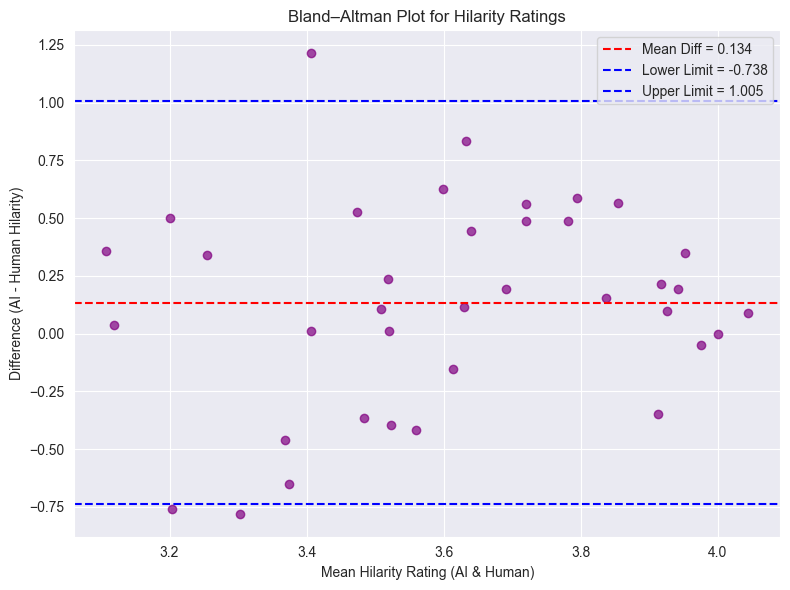

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Hilarity Ratings
##############################################
def aggregate_human_hilarity(df_human, min_evals):
    """
    For each meme in df_human (each combination of claim 1–12 and meme 1–8),
    if there are at least min_evals non-missing hilarity ratings (from the column
    "claimX_memeY_hilarity"), compute the average hilarity for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - hilarity_human (the aggregated human hilarity rating)
      - n_human (the number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_hilarity"
            if col not in df_human.columns:
                continue
            # Convert the column to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "hilarity_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Hilarity)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10  # set the minimum number of human evaluations per meme
df_human_hilarity = aggregate_human_hilarity(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human hilarity ratings (first 5 rows):")
print(df_human_hilarity.head())
print(f"DEBUG: Total memes aggregated from human hilarity ratings (n >= {min_threshold}): {df_human_hilarity.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Hilarity)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (if needed)
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI 'hilarity' metric from strings like "4/5" to numeric values.
df_ai['hilarity'] = df_ai['hilarity'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human data format ("claimX_memeY")
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI hilarity ratings per meme (averaging over all evaluations for that meme)
df_ai_agg = df_ai.groupby("meme_id")["hilarity"].mean().reset_index()
df_ai_agg.rename(columns={'hilarity': 'hilarity_ai'}, inplace=True)
print("DEBUG: Aggregated AI hilarity ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI hilarity ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Hilarity Ratings and Perform Bland–Altman Analysis
##############################################
df_merge = pd.merge(df_human_hilarity, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for hilarity):", df_merge.shape)
print("DEBUG: Merged sample (first 5 rows):")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    # Compute the difference (AI hilarity minus Human hilarity) and the mean of the two hilarity ratings.
    df_merge['difference'] = df_merge['hilarity_ai'] - df_merge['hilarity_human']
    df_merge['mean_hilarity'] = (df_merge['hilarity_ai'] + df_merge['hilarity_human']) / 2

    # Calculate Bland–Altman statistics.
    bias = df_merge['difference'].mean()
    sd_diff = df_merge['difference'].std()
    lower_limit = bias - 1.96 * sd_diff
    upper_limit = bias + 1.96 * sd_diff

    print("Bland–Altman Analysis Results for Hilarity:")
    print(f"  Mean difference (bias): {bias:.3f}")
    print(f"  Standard deviation of differences: {sd_diff:.3f}")
    print(f"  Lower limit of agreement: {lower_limit:.3f}")
    print(f"  Upper limit of agreement: {upper_limit:.3f}\n")
    
    ##############################################
    # Phase 4: Plot and Save the Bland–Altman Plot for Hilarity
    ##############################################
    plt.figure(figsize=(8, 6))
    plt.scatter(df_merge['mean_hilarity'], df_merge['difference'], color='purple', alpha=0.7)
    plt.axhline(bias, color='red', linestyle='--', label=f"Mean Diff = {bias:.3f}")
    plt.axhline(lower_limit, color='blue', linestyle='--', label=f"Lower Limit = {lower_limit:.3f}")
    plt.axhline(upper_limit, color='blue', linestyle='--', label=f"Upper Limit = {upper_limit:.3f}")
    plt.xlabel("Mean Hilarity Rating (AI & Human)")
    plt.ylabel("Difference (AI - Human Hilarity)")
    plt.title("Bland–Altman Plot for Hilarity Ratings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    output_dir = "../new_results"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "bland_altman_hilarity.png")
    plt.savefig(output_file)
    print(f"DEBUG: Hilarity Bland–Altman plot saved to {output_file}\n")
    plt.show()
else:
    print("No overlapping memes found between human and AI for hilarity!")

# Corr persuasiveness human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human persuasiveness ratings (first 5 rows):
        meme_id  persuasiveness_human  n_human
0  claim1_meme1              3.760000       50
1  claim1_meme3              3.900000       10
2  claim1_meme8              3.782609       23
3  claim2_meme2              3.400000       20
4  claim2_meme8              3.277778       36
DEBUG: Total memes aggregated from human persuasiveness ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI persuasiveness ratings (first 5 rows):
         meme_id  persuasiveness_ai
0  claim10_meme1             4.3250
1  claim10_meme2             4.3000
2  claim10_meme3             4.0250
3  claim10_meme4             4.1000
4  claim10_meme5             4.1375
DEBUG: Total memes aggregated from AI persuasiveness ratings: 96

DEBUG: Merged data shape (for persuasiveness): (37, 4)
DEBUG: Merged sample (first 5 rows):
        meme_id  persuasiveness_human  n_human  persuasiv

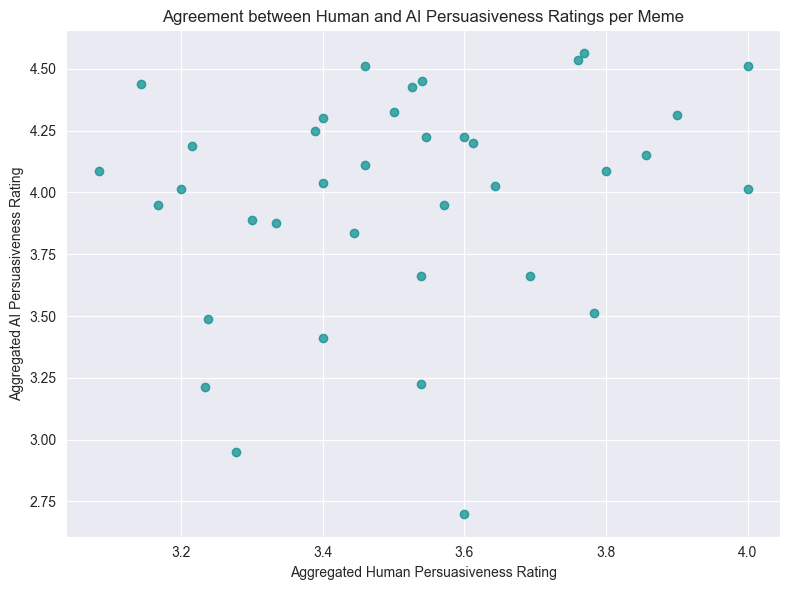

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Persuasiveness Ratings
##############################################
def aggregate_human_persuasiveness(df_human, min_evals):
    """
    For each meme (combination of claim and meme number) in df_human,
    if there are at least min_evals non-missing persuasiveness ratings (from the column
    "claimX_memeY_persuasiveness"), compute the average persuasiveness for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - persuasiveness_human (the aggregated human persuasiveness rating)
      - n_human (the number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):  # claims 1 to 12
        for meme in range(1, 9):  # memes 1 to 8 per claim
            col = f"claim{claim}_meme{meme}_persuasiveness"
            if col not in df_human.columns:
                continue
            # Convert the column to numeric and drop missing values
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "persuasiveness_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Persuasiveness)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10  # minimum number of human evaluations per meme
df_human_pers = aggregate_human_persuasiveness(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human persuasiveness ratings (first 5 rows):")
print(df_human_pers.head())
print(f"DEBUG: Total memes aggregated from human persuasiveness ratings (n >= {min_threshold}): {df_human_pers.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Persuasiveness)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (pooling all AI evaluations here)
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI 'persuasiveness' metric from strings like "4/5" to numeric values.
df_ai['persuasiveness'] = df_ai['persuasiveness'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human format ("claimX_memeY").
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI persuasiveness ratings per meme (averaging over all evaluations for each meme).
df_ai_agg = df_ai.groupby("meme_id")["persuasiveness"].mean().reset_index()
df_ai_agg.rename(columns={'persuasiveness': 'persuasiveness_ai'}, inplace=True)
print("DEBUG: Aggregated AI persuasiveness ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI persuasiveness ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Persuasiveness Ratings and Compute Pearson Correlation
##############################################
df_merge = pd.merge(df_human_pers, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for persuasiveness):", df_merge.shape)
print("DEBUG: Merged sample (first 5 rows):")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    r, p_val = pearsonr(df_merge['persuasiveness_human'], df_merge['persuasiveness_ai'])
    print(f"Pearson correlation for persuasiveness ratings (Human vs. AI): r = {r:.3f}, p = {p_val:.3e}")
else:
    print("No overlapping memes found between human and AI for persuasiveness!")

##############################################
# Phase 4: Plot the Agreement for Persuasiveness Ratings and Save the Plot
##############################################
plt.figure(figsize=(8, 6))
plt.scatter(df_merge['persuasiveness_human'], df_merge['persuasiveness_ai'], color='darkcyan', alpha=0.7)
plt.xlabel("Aggregated Human Persuasiveness Rating")
plt.ylabel("Aggregated AI Persuasiveness Rating")
plt.title("Agreement between Human and AI Persuasiveness Ratings per Meme")
plt.grid(True)
plt.tight_layout()

output_dir = "../new_results"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "persuasiveness_agreement.png")
plt.savefig(output_file)
print(f"DEBUG: Persuasiveness agreement plot saved to {output_file}")
plt.show()

# Altman persuasiveness human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human persuasiveness ratings (first 5 rows):
        meme_id  persuasiveness_human  n_human
0  claim1_meme1              3.760000       50
1  claim1_meme3              3.900000       10
2  claim1_meme8              3.782609       23
3  claim2_meme2              3.400000       20
4  claim2_meme8              3.277778       36
DEBUG: Total memes aggregated from human persuasiveness ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI persuasiveness ratings (first 5 rows):
         meme_id  persuasiveness_ai
0  claim10_meme1             4.3250
1  claim10_meme2             4.3000
2  claim10_meme3             4.0250
3  claim10_meme4             4.1000
4  claim10_meme5             4.1375
DEBUG: Total memes aggregated from AI persuasiveness ratings: 96

DEBUG: Merged data shape (for persuasiveness): (37, 4)
DEBUG: Merged sample (first 5 rows):
        meme_id  persuasiveness_human  n_human  persuasiv

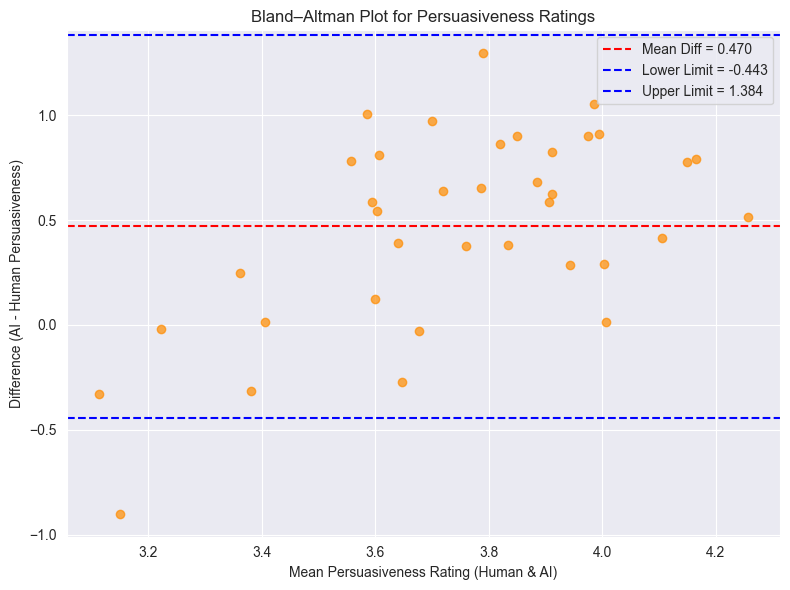

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Persuasiveness Ratings
##############################################
def aggregate_human_persuasiveness(df_human, min_evals):
    """
    For each meme in df_human (each combination of claim 1–12 and meme 1–8),
    if there are at least min_evals non-missing persuasiveness ratings (from the column
    "claimX_memeY_persuasiveness"), compute the average persuasiveness for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - persuasiveness_human (the aggregated human persuasiveness rating)
      - n_human (the number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_persuasiveness"
            if col not in df_human.columns:
                continue
            # Convert to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "persuasiveness_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Persuasiveness)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10  # Set minimum evaluations required per meme.
df_human_pers = aggregate_human_persuasiveness(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human persuasiveness ratings (first 5 rows):")
print(df_human_pers.head())
print(f"DEBUG: Total memes aggregated from human persuasiveness ratings (n >= {min_threshold}): {df_human_pers.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Persuasiveness)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase.
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI 'persuasiveness' metric from strings like "4/5" to numeric values.
df_ai['persuasiveness'] = df_ai['persuasiveness'].str.split('/').str[0].astype(float)

# Create a meme_id that matches the human format: "claimX_memeY"
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI persuasiveness ratings per meme (average over all evaluations).
df_ai_agg = df_ai.groupby("meme_id")["persuasiveness"].mean().reset_index()
df_ai_agg.rename(columns={'persuasiveness': 'persuasiveness_ai'}, inplace=True)
print("DEBUG: Aggregated AI persuasiveness ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI persuasiveness ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Persuasiveness Ratings and Compute Bland–Altman Statistics
##############################################
df_merge = pd.merge(df_human_pers, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for persuasiveness):", df_merge.shape)
print("DEBUG: Merged sample (first 5 rows):")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    # Compute the difference (AI persuasiveness minus Human persuasiveness) and the mean of the two ratings.
    df_merge['difference'] = df_merge['persuasiveness_ai'] - df_merge['persuasiveness_human']
    df_merge['mean_persuasiveness'] = (df_merge['persuasiveness_ai'] + df_merge['persuasiveness_human']) / 2

    # Calculate Bland–Altman statistics.
    bias = df_merge['difference'].mean()
    sd_diff = df_merge['difference'].std()
    lower_limit = bias - 1.96 * sd_diff
    upper_limit = bias + 1.96 * sd_diff

    print("Bland–Altman Analysis Results for Persuasiveness:")
    print(f"  Mean difference (bias): {bias:.3f}")
    print(f"  Standard deviation of differences: {sd_diff:.3f}")
    print(f"  Lower limit of agreement: {lower_limit:.3f}")
    print(f"  Upper limit of agreement: {upper_limit:.3f}\n")
    
    ##############################################
    # Phase 4: Plot and Save the Bland–Altman Plot for Persuasiveness
    ##############################################
    plt.figure(figsize=(8, 6))
    plt.scatter(df_merge['mean_persuasiveness'], df_merge['difference'], color='darkorange', alpha=0.7)
    plt.axhline(bias, color='red', linestyle='--', label=f"Mean Diff = {bias:.3f}")
    plt.axhline(lower_limit, color='blue', linestyle='--', label=f"Lower Limit = {lower_limit:.3f}")
    plt.axhline(upper_limit, color='blue', linestyle='--', label=f"Upper Limit = {upper_limit:.3f}")
    plt.xlabel("Mean Persuasiveness Rating (Human & AI)")
    plt.ylabel("Difference (AI - Human Persuasiveness)")
    plt.title("Bland–Altman Plot for Persuasiveness Ratings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    output_dir = "../new_results"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "bland_altman_persuasiveness.png")
    plt.savefig(output_file)
    print(f"DEBUG: Persuasiveness Bland–Altman plot saved to {output_file}\n")
    plt.show()
else:
    print("No overlapping memes found between human and AI for persuasiveness!")

# Corr template appro human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human template ratings (first 5 rows):
        meme_id  template_human  n_human
0  claim1_meme1        4.140000       50
1  claim1_meme3        4.200000       10
2  claim1_meme8        3.913043       23
3  claim2_meme2        3.700000       20
4  claim2_meme8        3.611111       36
DEBUG: Total memes aggregated from human template ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI template ratings (first 5 rows):
         meme_id  template_ai
0  claim10_meme1       4.5875
1  claim10_meme2       4.7500
2  claim10_meme3       4.3750
3  claim10_meme4       4.3125
4  claim10_meme5       4.4500
DEBUG: Total memes aggregated from AI template ratings: 96

DEBUG: Merged data shape (for template): (37, 4)
DEBUG: Merged sample (first 5 rows):
        meme_id  template_human  n_human  template_ai
0  claim1_meme1        4.140000       50       4.9125
1  claim1_meme3        4.200000       10       4.75

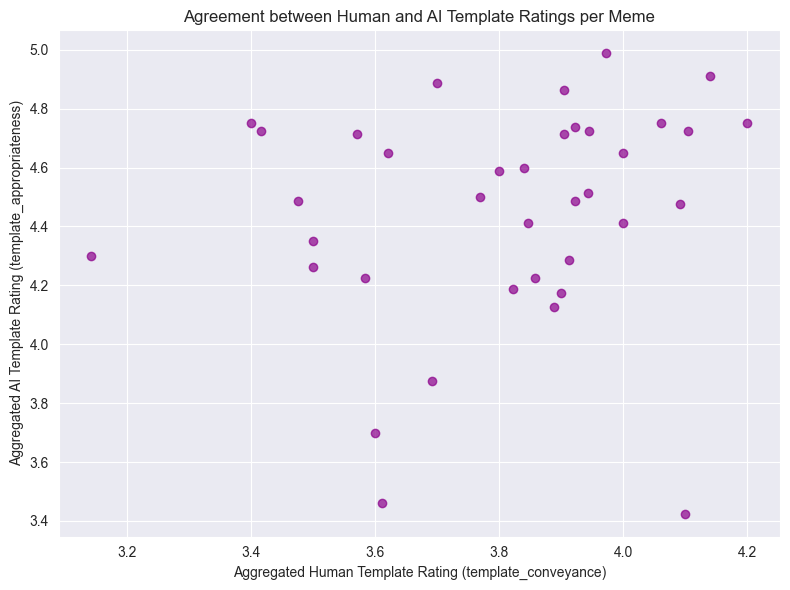

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Template Ratings
##############################################
def aggregate_human_template(df_human, min_evals):
    """
    For each meme (combination of claim 1–12 and meme 1–8) in the human data file,
    if there are at least min_evals complete ratings for the template metric
    (from the column "claimX_memeY_template_conveyance"),
    compute the average template rating (template_conveyance) for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - template_human (the aggregated human template_conveyance rating)
      - n_human (number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_template_conveyance"
            if col not in df_human.columns:
                continue
            # Convert the column to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "template_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Template)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10  # Minimum evaluations per meme
df_human_template = aggregate_human_template(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human template ratings (first 5 rows):")
print(df_human_template.head())
print(f"DEBUG: Total memes aggregated from human template ratings (n >= {min_threshold}): {df_human_template.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Template)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (if needed)
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI template metric from strings like "4/5" to numeric values.
df_ai['template_appropriateness'] = df_ai['template_appropriateness'].str.split('/').str[0].astype(float)

# Create a meme_id for AI data that matches the human format: "claimX_memeY"
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI template ratings per meme (average over all evaluations)
df_ai_agg = df_ai.groupby("meme_id")["template_appropriateness"].mean().reset_index()
df_ai_agg.rename(columns={'template_appropriateness': 'template_ai'}, inplace=True)
print("DEBUG: Aggregated AI template ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI template ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Template Data and Compute Pearson Correlation
##############################################
df_merge = pd.merge(df_human_template, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for template):", df_merge.shape)
print("DEBUG: Merged sample (first 5 rows):")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    r, p_val = pearsonr(df_merge['template_human'], df_merge['template_ai'])
    print(f"Pearson correlation for template ratings (Human vs. AI): r = {r:.3f}, p = {p_val:.3e}")
else:
    print("No overlapping memes found between human and AI for template ratings!")

##############################################
# Phase 4: Plot the Agreement for Template Ratings and Save the Plot
##############################################
plt.figure(figsize=(8, 6))
plt.scatter(df_merge['template_human'], df_merge['template_ai'], color='darkmagenta', alpha=0.7)
plt.xlabel("Aggregated Human Template Rating (template_conveyance)")
plt.ylabel("Aggregated AI Template Rating (template_appropriateness)")
plt.title("Agreement between Human and AI Template Ratings per Meme")
plt.grid(True)
plt.tight_layout()

output_dir = "../new_results"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "template_agreement.png")
plt.savefig(output_file)
print(f"DEBUG: Template agreement plot saved to {output_file}")
plt.show()

# Altman template appro human vs ai evals

DEBUG: Human data loaded. Shape: (110, 553)
DEBUG: Aggregated human template ratings (first 5 rows):
        meme_id  template_human  n_human
0  claim1_meme1        4.140000       50
1  claim1_meme3        4.200000       10
2  claim1_meme8        3.913043       23
3  claim2_meme2        3.700000       20
4  claim2_meme8        3.611111       36
DEBUG: Total memes aggregated from human template ratings (n >= 10): 37

DEBUG: AI data loaded. Shape: (7680, 20)
DEBUG: Aggregated AI template ratings (first 5 rows):
         meme_id  template_ai
0  claim10_meme1       4.5875
1  claim10_meme2       4.7500
2  claim10_meme3       4.3750
3  claim10_meme4       4.3125
4  claim10_meme5       4.4500
DEBUG: Total memes aggregated from AI template ratings: 96

DEBUG: Merged data shape (for template): (37, 4)
DEBUG: Merged sample (first 5 rows):
        meme_id  template_human  n_human  template_ai
0  claim1_meme1        4.140000       50       4.9125
1  claim1_meme3        4.200000       10       4.75

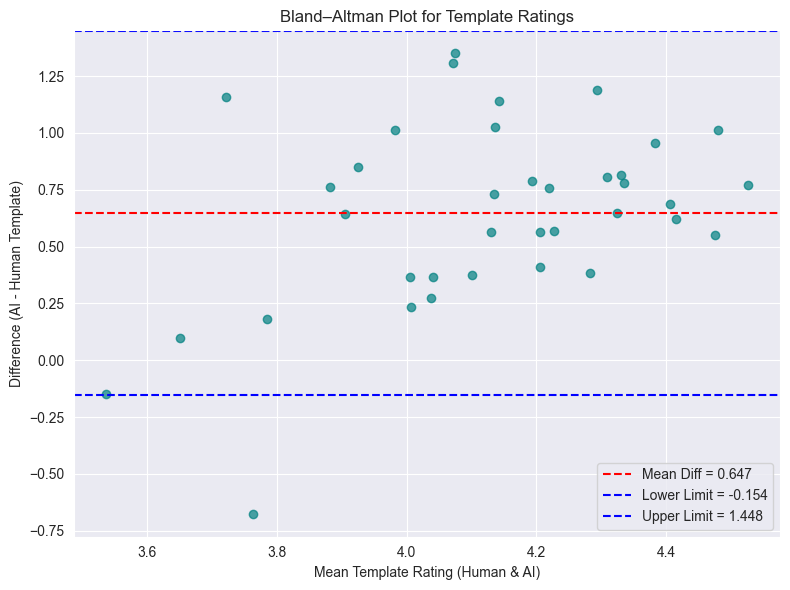

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

##############################################
# Helper Function: Aggregate Human Template Ratings
##############################################
def aggregate_human_template(df_human, min_evals):
    """
    For each meme (each combination of claim 1–12 and meme 1–8) in the human evaluations file,
    if there are at least min_evals complete template ratings (from the column 
    "claimX_memeY_template_conveyance"), compute the average human template rating for that meme.
    
    Returns a DataFrame with columns:
      - meme_id (formatted as "claimX_memeY")
      - template_human (aggregated human template_conveyance rating)
      - n_human (number of ratings used)
    """
    human_list = []
    for claim in range(1, 13):
        for meme in range(1, 9):
            col = f"claim{claim}_meme{meme}_template_conveyance"
            if col not in df_human.columns:
                continue
            # Convert the values to numeric and drop missing values.
            ratings = pd.to_numeric(df_human[col], errors='coerce').dropna()
            if ratings.shape[0] < min_evals:
                continue
            avg_rating = ratings.mean()
            meme_id = f"claim{claim}_meme{meme}"
            human_list.append({
                "meme_id": meme_id,
                "template_human": avg_rating,
                "n_human": ratings.shape[0]
            })
    return pd.DataFrame(human_list)

##############################################
# Phase 1: Process Human Evaluation Data (Template)
##############################################
human_path = "../llm_selection/data/postselection_meme_ratings_processed.csv"
df_human = pd.read_csv(human_path)
print("DEBUG: Human data loaded. Shape:", df_human.shape)

min_threshold = 10  # Set minimum number of human evaluations per meme.
df_human_template = aggregate_human_template(df_human, min_evals=min_threshold)
print("DEBUG: Aggregated human template ratings (first 5 rows):")
print(df_human_template.head())
print(f"DEBUG: Total memes aggregated from human template ratings (n >= {min_threshold}): {df_human_template.shape[0]}\n")

##############################################
# Phase 2: Process AI Evaluation Data (Template)
##############################################
ai_path = "plots/2025_02_21_23_04_10.csv"
df_ai = pd.read_csv(ai_path)
print("DEBUG: AI data loaded. Shape:", df_ai.shape)

# Standardize model names to lowercase (we assume we're pooling all AI evaluations for template)
df_ai['model_name_judge'] = df_ai['model_name_judge'].str.lower()

# Convert the AI template metric from strings like "4/5" to numeric.
df_ai['template_appropriateness'] = df_ai['template_appropriateness'].str.split('/').str[0].astype(float)

# Create a meme_id matching the human data format ("claimX_memeY").
df_ai['claim_number'] = df_ai['claim_number'].astype(str)
df_ai['meme_id'] = "claim" + df_ai['claim_number'] + "_meme" + df_ai['meme_number'].astype(str)

# Aggregate AI template ratings per meme (average over all evaluations).
df_ai_agg = df_ai.groupby("meme_id")["template_appropriateness"].mean().reset_index()
df_ai_agg.rename(columns={'template_appropriateness': 'template_ai'}, inplace=True)
print("DEBUG: Aggregated AI template ratings (first 5 rows):")
print(df_ai_agg.head())
print(f"DEBUG: Total memes aggregated from AI template ratings: {df_ai_agg.shape[0]}\n")

##############################################
# Phase 3: Merge Human and AI Template Data and Compute Bland–Altman Statistics
##############################################
df_merge = pd.merge(df_human_template, df_ai_agg, on="meme_id")
print("DEBUG: Merged data shape (for template):", df_merge.shape)
print("DEBUG: Merged sample (first 5 rows):")
print(df_merge.head(), "\n")

if df_merge.shape[0] > 0:
    # Compute the difference: AI template rating minus Human template rating.
    df_merge['difference'] = df_merge['template_ai'] - df_merge['template_human']
    # Compute the mean of the two ratings for each meme.
    df_merge['mean_template'] = (df_merge['template_ai'] + df_merge['template_human']) / 2

    # Compute Bland–Altman statistics.
    bias = df_merge['difference'].mean()
    sd_diff = df_merge['difference'].std()
    lower_limit = bias - 1.96 * sd_diff
    upper_limit = bias + 1.96 * sd_diff

    print("Bland–Altman Analysis Results for Template:")
    print(f"  Mean difference (bias): {bias:.3f}")
    print(f"  Standard deviation of differences: {sd_diff:.3f}")
    print(f"  Lower limit of agreement: {lower_limit:.3f}")
    print(f"  Upper limit of agreement: {upper_limit:.3f}\n")

    ##############################################
    # Phase 4: Plot the Bland–Altman Plot for Template and Save the Plot
    ##############################################
    plt.figure(figsize=(8, 6))
    plt.scatter(df_merge['mean_template'], df_merge['difference'], color='teal', alpha=0.7)
    plt.axhline(bias, color='red', linestyle='--', label=f"Mean Diff = {bias:.3f}")
    plt.axhline(lower_limit, color='blue', linestyle='--', label=f"Lower Limit = {lower_limit:.3f}")
    plt.axhline(upper_limit, color='blue', linestyle='--', label=f"Upper Limit = {upper_limit:.3f}")
    plt.xlabel("Mean Template Rating (Human & AI)")
    plt.ylabel("Difference (AI - Human Template)")
    plt.title("Bland–Altman Plot for Template Ratings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    output_dir = "../new_results"
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "bland_altman_template.png")
    plt.savefig(output_file)
    print(f"DEBUG: Template Bland–Altman plot saved to {output_file}\n")
    plt.show()
else:
    print("No overlapping memes found between human and AI for template ratings!")